# OCRA Demo
This notebook shows how to train or test the model. Also included are methods to display model outputs and attention mechanimsms 

In [1]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

# Instantiate Model for Training

In [2]:
############################################
# set hyperparams using param file 
############################################
# param file can be 1) multimnist_params.txt or 2) multimnist_cluttered_params.txt
# params_filename = 'multimnist_cluttered_params.txt'
# params_filename = 'multisvhn_params.txt'
params_filename = 'multimnist_params_3glimpse.txt'
args = parse_params(params_filename)

# if you have a checkpoint to restore, specify restore file (in the orginal param file or here)
# args.restore_file =  'results/multimnist_cluttered/Aug28_4014__step7_1/state_checkpoint.pt'
if args.restore_file: 
    # if you want to pick up from save-point, reload param files
    print("param file will be reloaded from your save point folder")
    path_savepoint = os.path.dirname(args.restore_file)
    params_filename = path_savepoint + '/params.txt'  
    assert os.path.isfile(params_filename), "No param flie exists"
    
    # remove the arguments that cannot be translated into literal
    removelist = ['device'] 
    args = parse_params_wremove(params_filename, removelist) 
    
    # reassign path_savepoint to restorefile
    args.restore_file = path_savepoint + '/state_checkpoint.pt'
            
# if recon_model=False, makes loss from reconstruciton 0
if not args.recon_model:
    args.lam_recon=0
    
# setup output directory where log folder should be created 
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# set device
# args.device = torch.device('cuda:{}'.format(args.cuda) if torch.cuda.is_available() and args.cuda is not None else 'cpu')
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

############################################
# instantiate model 
############################################
# set up model, optimizer, and hooks for monitoring
model = OCRA(args).to(args.device) 
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.5, 0.999))
# if args.record_attn_hooks:
#     record_forward_backward_attn_hooks(model)

# print model info
pprint.pprint(args.__dict__, sort_dicts=False)
count_parameters(model)

{'task': 'multimnist',
 'num_classes': 10,
 'num_targets': 2,
 'image_dims': (1, 36, 36),
 'cat_dup': False,
 'n_epochs': 50,
 'lr': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 128,
 'cuda': 0,
 'data_dir': '../data/',
 'output_dir': './results/multimnist/',
 'restore_file': None,
 'save_checkpoint': True,
 'record_gradnorm': False,
 'record_attn_hooks': False,
 'validate_after_howmany_epochs': 1,
 'best_val_acc': 0,
 'verbose': True,
 'use_read_attn': True,
 'read_size': 18,
 'use_write_attn': True,
 'write_size': 18,
 'use_backbone': 'conv_small',
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'time_steps': 3,
 'include_xhat': False,
 'lstm_size': 512,
 'decoder_encoder_feedback': False,
 'use_capsnet': True,
 'num_zcaps': 40,
 'dim_zcaps': 8,
 'routings': 3,
 'dim_objectcaps': 16,
 'backg_objcaps': 0,
 'mask_objectcaps': True,
 'class_cond_mask': False,
 'recon_model': True,
 'lam_recon': 3,
 'clip_c': True,
 'use_recon_mask': False,
 'device': device(type='cuda', index=0)}

3877356

## start training

In [3]:
###########################
# model training...
##########################

DO_TRAIN = True  # false if you want to skip this cell
COMMENT = 'test'

if DO_TRAIN:
    # load dataloader 
    train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')

    # set writer for tensorboard
    writer, current_log_path = set_writer(log_path = args.output_dir if args.restore_file is None else os.path.dirname(args.restore_file),
                        comment = COMMENT, 
                        restore = args.restore_file is not None) 

    args.log_dir = current_log_path

    # save used param info to writer and logging directory
    writer.add_text('Params', pprint.pformat(args.__dict__))
    
    with open(os.path.join(args.log_dir, 'params.txt'), 'w') as f:
        pprint.pprint(args.__dict__, f, sort_dicts=False)

    # start training
    print('Start training with args set above...')
    train_and_evaluate(model, train_dataloader, val_dataloader, loss_fn, optimizer, writer, args)

    writer.close()

epoch 1 of 50:   0%|                                                                         | 0/21094 [00:00<?, ?it/s]

Start training with args set above...


epoch 2 of 50:   0%|                                               | 2/21094 [00:00<20:12, 17.39it/s, batch_loss=0.158]

==> Epoch 01: train_loss=0.00191, val_loss=0.00116, val_L_recon=0.00040, val_L_margin=0.00076, val_acc_partial=0.9376,  val_acc_exact=0.8789
the model with best val_acc (0.8789) was saved to disk


epoch 2 of 50:   0%|                                              | 22/21094 [00:02<33:22, 10.52it/s, batch_loss=0.157]


KeyboardInterrupt: 

# Test pretrained models

In [ ]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

In [4]:
###########################
# model testing...
##########################

# testing parameters
DO_TEST = True # false if you want to skip this cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# give path for the model to load, or None if you want to continue with the current trained model
# load_model_path = "./pretrained/multimnist_cluttered/run1.pt"
load_model_path = None
#load_model_path = './pretrained/cluttered-5glimpse/best_model_epoch687.pt'
if DO_TEST:
    if load_model_path: 
        # if path is given, load a saved model (make sure that you loaded right model args)
        print("param file will be loaded from your saved model folder")
        params_filename = os.path.dirname(load_model_path) + '/params.txt'
        assert os.path.isfile(params_filename), "No param flie exists"

        # remove the arguments that caanot be translated into literal
        removelist = ['device'] 
        args = parse_params_wremove(params_filename, removelist) 
        args.device = device 
        
        # print params
        pprint.pprint(args.__dict__, sort_dicts=False)
        
        args.use_capsnet= True
        args.num_zcaps=40
        args.use_backbone ='conv_small'
        # load model
        model = OCRA(args).to(args.device) 
        model.load_state_dict(torch.load(load_model_path,map_location=args.device))
        print('model loaded.')
        
        # get test results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

    else: # use the current trained model to get results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

==> Epoch 50: test_loss=0.00116, test_L_recon=0.00039, test_L_margin=0.00077, test_acc_partial=0.9368, test_acc_exact=0.8775


##  Examining model outputs on a single test batch & plotting 

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
to_img = ToPILImage()
from PIL import Image
import os.path
import glob
import numpy as np
import math
import copy 
from matplotlib.patches import Rectangle
from IPython.display import Image as IP_Image

In [6]:
# Putting hooks to gather attention parameters
from functools import partial

read_mu_xs = []
read_mu_ys = []
def record_read_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    read_mu_xs.append(mu_x)
    read_mu_ys.append(mu_y)
    
model.read_attention_linear.register_forward_hook(partial(record_read_attn_params, bank_name='read'))


write_mu_xs = []
write_mu_ys = []
def record_write_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    write_mu_xs.append(mu_x)
    write_mu_ys.append(mu_y)

model.write_attention_linear.register_forward_hook(partial(record_write_attn_params, bank_name='write'))

# activation = []
# def get_activation(name):
#     def hook(model, input, output):
#         activation.append(output.detach())
#         print(output.detach().shape)
#     return hook

# model.bb_conv1.register_forward_hook(get_activation('bb_conv1'))

In [7]:
# test the model accuracy on a single batch 
test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
x, y = next(iter(test_dataloader))
y = y.type(torch.int64)
    
top_k = args.num_targets

# if one target and y is not in one-hot format, convert it to one-hot encoding
if args.num_targets == 1:
    if len(y.shape) < 2: 
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), args.num_classes).scatter_(1, y.view(-1, 1), 1.) 

batch_loss, batch_L_recon, batch_L_margin, batch_correct_exact, batch_correct_partial, read_x_step, \
        c_each, y_pred, objcaps_len_step, readout_logits =  evaluate(model, x, y, loss_fn, args)


read_x_step = torch.reshape(read_x_step, (args.test_batch_size,-1, *args.image_dims))
c_each = torch.reshape(c_each, (args.test_batch_size,-1, *args.image_dims))

test_loss = batch_loss / args.test_batch_size
test_L_recon = batch_L_recon / args.test_batch_size
test_L_margin = batch_L_margin / args.test_batch_size
test_acc_partial = batch_correct_partial / args.test_batch_size
test_acc_exact = batch_correct_exact / args.test_batch_size

# for visualization 
if args.task == 'mnist_ctrv':
    x = 1.0 - x

print("==> On sigle test batch: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
      % (test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

==> On sigle test batch: test_loss=0.00112, test_L_recon=0.00039, test_L_margin=0.00073, test_acc_partial=0.9492, test_acc_exact=0.9062


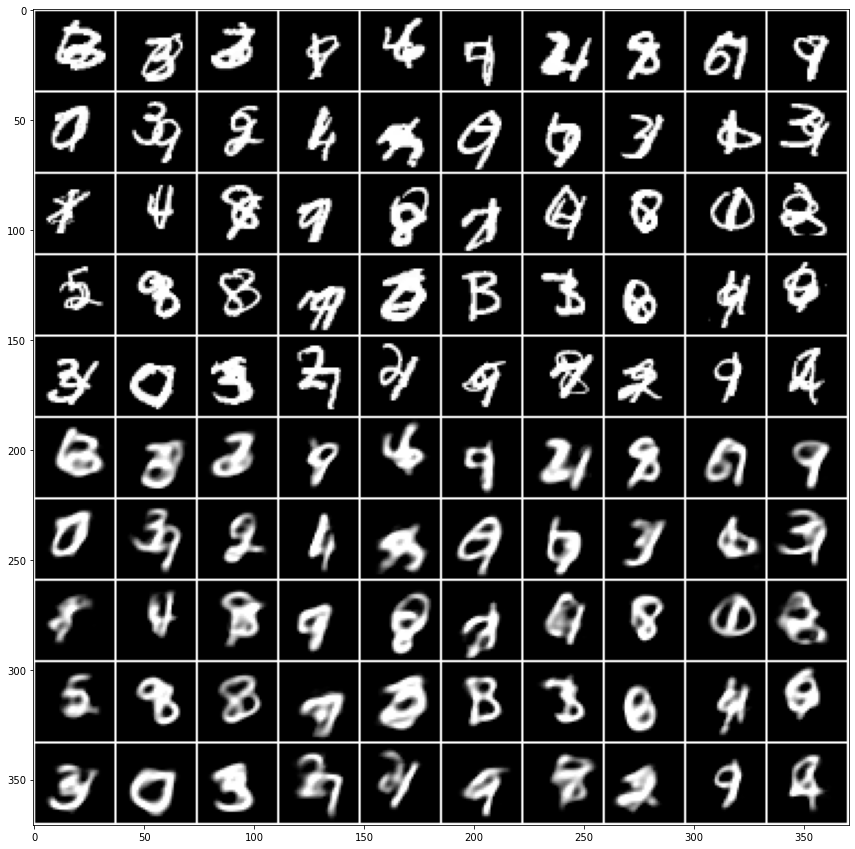

torch.Size([384, 1, 36, 36])


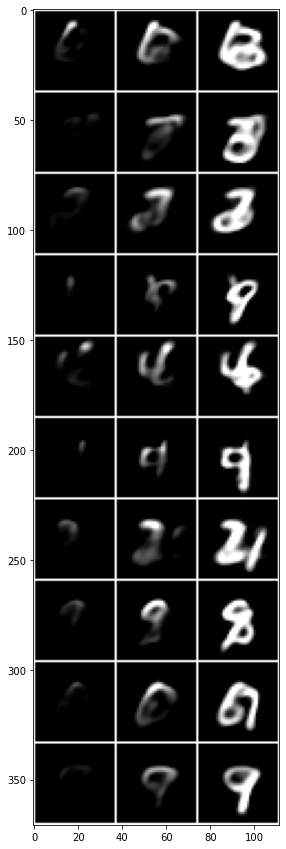

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


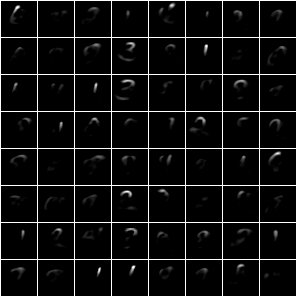

In [8]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# plot and save image outputs
img_g = torch.cat((x[:50].to(args.device),torch.sum(c_each,dim=1)[:50]))
img_g = make_grid(img_g, nrow=10, padding=1, normalize=False, pad_value=1)
save_name = 'image_grid_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size, args.time_steps, args.num_targets)
save_image(img_g, os.path.join(args.output_dir, save_name))
img_g = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(img_g) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# reconstructoin steps
c_cumu_step = []
for i in range(args.time_steps):
    c_cumu_step.append(torch.squeeze(torch.cumsum(c_each,dim=1).narrow(1,i,1)))
        
        
num_imgs = 10
images = torch.stack(c_cumu_step, dim=1).view(-1, *args.image_dims)  # reshape to (10*time_steps, 1, 28, 28)
print(images.shape)
images = make_grid(images[0:num_imgs*len(c_cumu_step)], nrow=len(c_cumu_step), padding=1, normalize=False, pad_value=1)
save_name = 'generated_sequences_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size,args.time_steps,args.num_targets)


save_image(images, os.path.join(args.output_dir, save_name))
images = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(images) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# make gif
num_imgs = 64
c_cumu_step_gif = copy.deepcopy(c_cumu_step)
for i in range(len(c_cumu_step)):
    # convert sequence of image tensors to 8x8 grid
    image = make_grid(c_cumu_step[i][:num_imgs].view(-1, *args.image_dims).clip(max=1).cpu(), \
                      nrow=int(math.sqrt(num_imgs)), padding=1, normalize=False, pad_value=1)
    # make into gif
    c_cumu_step_gif[i] = image.data.numpy().transpose(1,2,0)

import imageio
file_add = (os.path.join(args.output_dir, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
imageio.mimsave(file_add, c_cumu_step_gif)

IP_Image(open(file_add,'rb').read(), width = 600, height = 600)

## Plotting attention windows for all timesteps 


****************************************************************************************************
trial 0

ground truth
tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
tensor([3, 6])
model prediction
tensor([0.0535, 0.0334, 0.5995, 0.5651, 0.0463, 0.0430, 1.0000, 0.0542, 0.0377,
        0.0600])
tensor([False, False,  True, False, False, False,  True, False, False, False])
tensor([2, 6])
partial score, 0.5, exact score, False


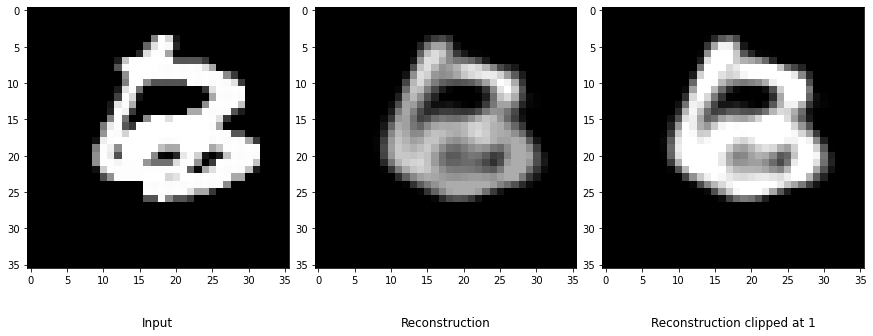

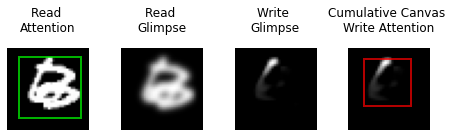

tensor([0.0488, 0.0304, 0.1200, 0.0424, 0.0277, 0.0273, 0.1890, 0.0455, 0.0185,
        0.0454])
tensor([6, 2, 0, 7, 9, 3, 1, 4, 5, 8])


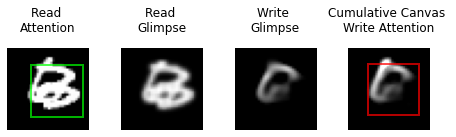

tensor([0.0104, 0.0044, 0.3452, 0.1397, 0.0078, 0.0061, 0.4749, 0.0121, 0.0155,
        0.0125])
tensor([6, 2, 3, 8, 9, 7, 0, 4, 5, 1])


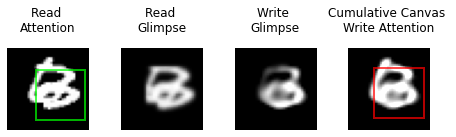

tensor([0.0124, 0.0098, 0.3376, 0.5746, 0.0265, 0.0243, 0.6752, 0.0149, 0.0165,
        0.0224])
tensor([6, 3, 2, 4, 5, 9, 8, 7, 0, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0716, 0.0447, 0.8028, 0.7568, 0.0620, 0.0576, 1.3391, 0.0725, 0.0505,
        0.0803], device='cuda:0')
tensor([6, 2, 3, 9, 7, 0, 4, 5, 8, 1], device='cuda:0')

****************************************************************************************************
trial 1

ground truth
tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 3])
model prediction
tensor([0.9200, 0.0786, 0.1308, 1.0000, 0.0918, 0.1032, 0.0802, 0.1560, 0.2891,
        0.1009])
tensor([ True, False, False,  True, False, False, False, False, False, False])
tensor([0, 3])
partial score, 1.0, exact score, True


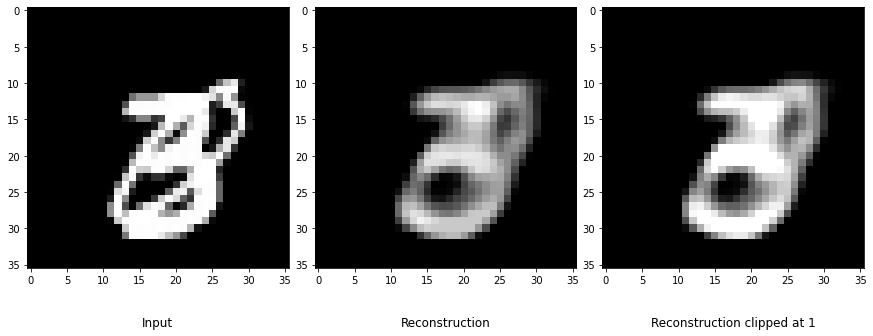

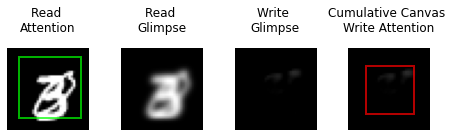

tensor([0.0536, 0.0509, 0.0879, 0.0254, 0.0606, 0.0395, 0.0518, 0.0985, 0.0202,
        0.0166])
tensor([7, 2, 4, 0, 6, 1, 5, 3, 8, 9])


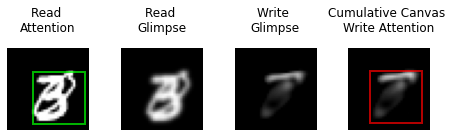

tensor([0.1661, 0.0094, 0.0110, 0.1296, 0.0103, 0.0235, 0.0156, 0.0428, 0.0348,
        0.0390])
tensor([0, 3, 7, 9, 8, 5, 6, 2, 4, 1])


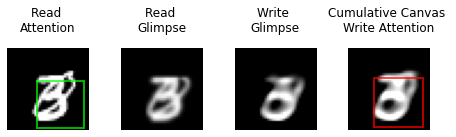

tensor([0.6444, 0.0135, 0.0239, 0.7842, 0.0154, 0.0339, 0.0079, 0.0051, 0.2165,
        0.0391])
tensor([3, 0, 8, 9, 5, 2, 4, 1, 6, 7])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.8641, 0.0738, 0.1229, 0.9392, 0.0863, 0.0969, 0.0754, 0.1465, 0.2715,
        0.0947], device='cuda:0')
tensor([3, 0, 8, 7, 2, 5, 9, 4, 6, 1], device='cuda:0')

****************************************************************************************************
trial 2

ground truth
tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0])
tensor([2, 3])
model prediction
tensor([0.0314, 0.1212, 0.9271, 0.7280, 0.0466, 0.0439, 1.0000, 0.0916, 0.0979,
        0.0213])
tensor([False, False,  True, False, False, False,  True, False, False, False])
tensor([2, 6])
partial score, 0.5, exact score, False


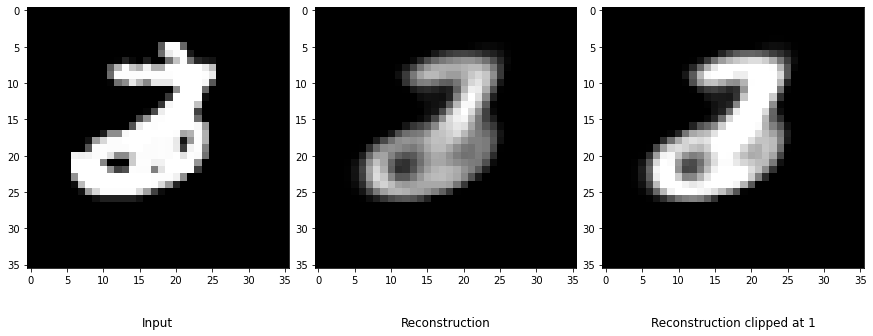

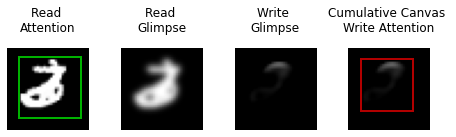

tensor([0.0155, 0.0830, 0.1359, 0.0168, 0.0237, 0.0064, 0.0382, 0.0486, 0.0466,
        0.0066])
tensor([2, 1, 7, 8, 6, 4, 3, 0, 9, 5])


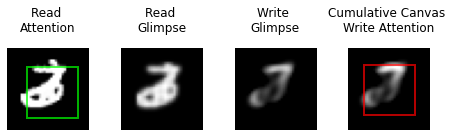

tensor([0.0076, 0.0243, 0.2916, 0.3010, 0.0058, 0.0057, 0.3928, 0.0180, 0.0108,
        0.0092])
tensor([6, 3, 2, 1, 7, 8, 9, 0, 4, 5])


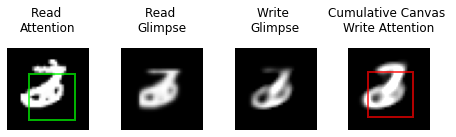

tensor([0.0084, 0.0141, 0.5013, 0.4116, 0.0172, 0.0319, 0.5709, 0.0251, 0.0407,
        0.0056])
tensor([6, 2, 3, 8, 5, 7, 4, 1, 0, 9])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0315, 0.1214, 0.9288, 0.7294, 0.0467, 0.0440, 1.0019, 0.0918, 0.0981,
        0.0213], device='cuda:0')
tensor([6, 2, 3, 1, 8, 7, 4, 5, 0, 9], device='cuda:0')

****************************************************************************************************
trial 3

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 9])
model prediction
tensor([0.0594, 1.0000, 0.0550, 0.0475, 0.0624, 0.0256, 0.0305, 0.0636, 0.0490,
        0.9781])
tensor([False,  True, False, False, False, False, False, False, False,  True])
tensor([1, 9])
partial score, 1.0, exact score, True


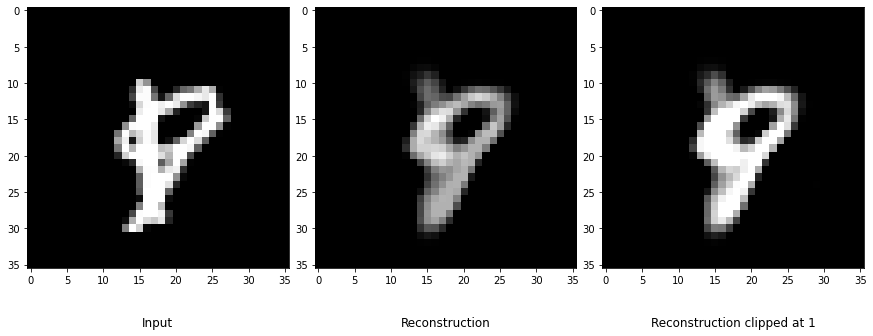

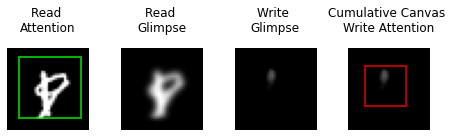

tensor([0.0080, 0.1327, 0.0286, 0.0058, 0.0172, 0.0144, 0.0217, 0.0423, 0.0056,
        0.0070])
tensor([1, 7, 2, 6, 4, 5, 0, 9, 3, 8])


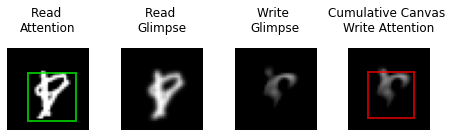

tensor([0.0096, 0.4378, 0.0280, 0.0134, 0.0379, 0.0086, 0.0090, 0.0139, 0.0110,
        0.4637])
tensor([9, 1, 4, 2, 7, 3, 8, 0, 6, 5])


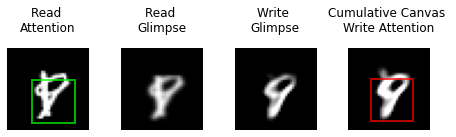

tensor([0.0624, 0.7769, 0.0174, 0.0447, 0.0289, 0.0115, 0.0104, 0.0296, 0.0495,
        0.8471])
tensor([9, 1, 0, 8, 3, 7, 4, 2, 5, 6])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0800, 1.3473, 0.0741, 0.0640, 0.0840, 0.0345, 0.0411, 0.0857, 0.0661,
        1.3178], device='cuda:0')
tensor([1, 9, 7, 4, 0, 2, 8, 3, 6, 5], device='cuda:0')

****************************************************************************************************
trial 4

ground truth
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])
tensor([4, 6])
model prediction
tensor([0.0343, 0.0426, 0.0330, 0.0480, 1.0000, 0.0360, 0.9699, 0.0268, 0.0183,
        0.0232])
tensor([False, False, False, False,  True, False,  True, False, False, False])
tensor([4, 6])
partial score, 1.0, exact score, True


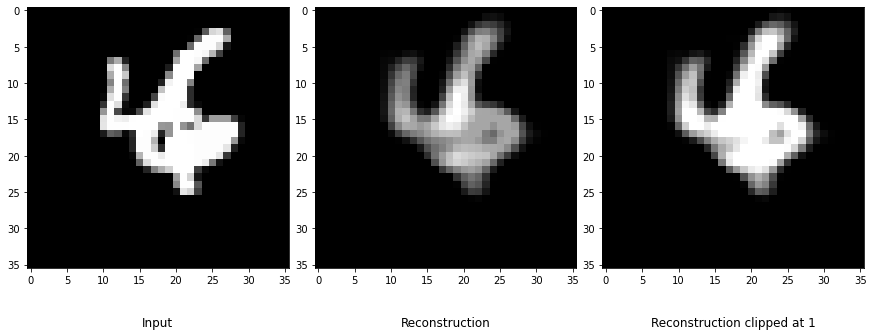

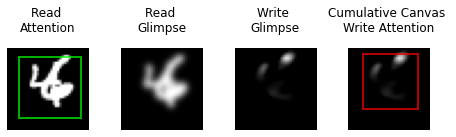

tensor([0.0086, 0.0413, 0.0114, 0.0285, 0.1766, 0.0241, 0.2986, 0.0099, 0.0086,
        0.0103])
tensor([6, 4, 1, 3, 5, 2, 9, 7, 0, 8])


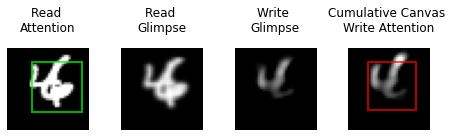

tensor([0.0176, 0.0072, 0.0103, 0.0311, 0.6361, 0.0131, 0.5425, 0.0121, 0.0127,
        0.0101])
tensor([4, 6, 3, 0, 5, 8, 7, 2, 9, 1])


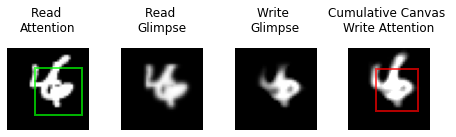

tensor([0.0285, 0.0194, 0.0309, 0.0169, 0.7821, 0.0202, 0.7057, 0.0207, 0.0080,
        0.0167])
tensor([4, 6, 2, 0, 7, 5, 1, 3, 9, 8])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0547, 0.0680, 0.0526, 0.0765, 1.5948, 0.0574, 1.5468, 0.0427, 0.0292,
        0.0371], device='cuda:0')
tensor([4, 6, 3, 1, 5, 0, 2, 7, 9, 8], device='cuda:0')

****************************************************************************************************
trial 5

ground truth
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
tensor([4, 7])
model prediction
tensor([0.0264, 0.2431, 0.0881, 0.0777, 1.0000, 0.0372, 0.0471, 0.9668, 0.0418,
        0.1887])
tensor([False, False, False, False,  True, False, False,  True, False, False])
tensor([4, 7])
partial score, 1.0, exact score, True


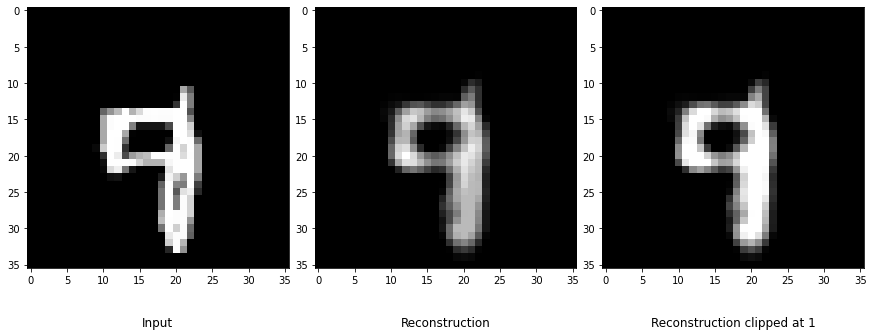

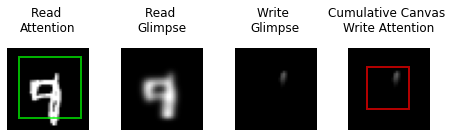

tensor([0.0046, 0.1456, 0.0580, 0.0213, 0.0307, 0.0078, 0.0272, 0.0798, 0.0057,
        0.0114])
tensor([1, 7, 2, 4, 6, 3, 9, 5, 8, 0])


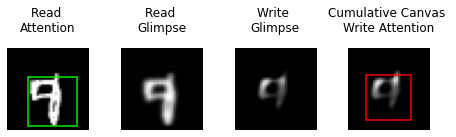

tensor([0.0104, 0.0688, 0.0247, 0.0309, 0.3626, 0.0161, 0.0094, 0.2409, 0.0263,
        0.1036])
tensor([4, 7, 9, 1, 3, 8, 2, 5, 0, 6])


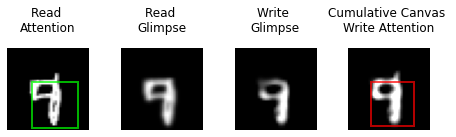

tensor([0.0126, 0.0402, 0.0096, 0.0292, 0.6535, 0.0151, 0.0127, 0.6913, 0.0117,
        0.0826])
tensor([7, 4, 9, 1, 3, 5, 6, 0, 8, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0276, 0.2545, 0.0922, 0.0814, 1.0468, 0.0390, 0.0493, 1.0120, 0.0437,
        0.1976], device='cuda:0')
tensor([4, 7, 1, 9, 2, 3, 6, 8, 5, 0], device='cuda:0')

****************************************************************************************************
trial 6

ground truth
tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([2, 4])
model prediction
tensor([0.0587, 0.0463, 0.8337, 0.0707, 1.0000, 0.0367, 0.0512, 0.0623, 0.0990,
        0.0457])
tensor([False, False,  True, False,  True, False, False, False, False, False])
tensor([2, 4])
partial score, 1.0, exact score, True


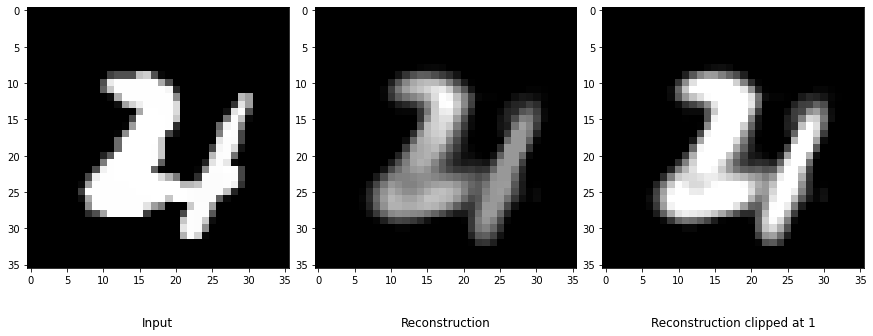

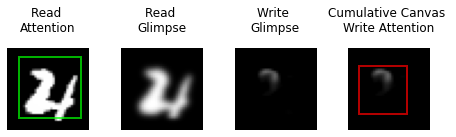

tensor([0.0387, 0.0308, 0.1360, 0.0467, 0.0542, 0.0097, 0.0286, 0.0438, 0.0263,
        0.0178])
tensor([2, 4, 3, 7, 0, 1, 6, 8, 9, 5])


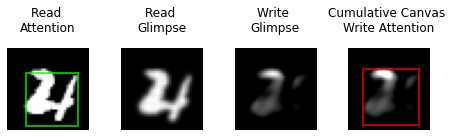

tensor([0.0355, 0.0102, 0.4955, 0.0449, 0.5775, 0.0327, 0.0183, 0.0205, 0.0828,
        0.0295])
tensor([4, 2, 8, 3, 0, 5, 9, 7, 6, 1])


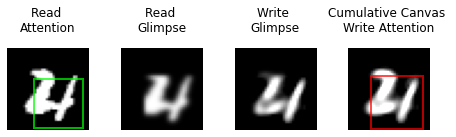

tensor([0.0090, 0.0247, 0.5507, 0.0087, 0.7863, 0.0096, 0.0257, 0.0241, 0.0313,
        0.0175])
tensor([4, 2, 8, 6, 1, 7, 9, 5, 0, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0832, 0.0657, 1.1822, 0.1002, 1.4180, 0.0520, 0.0726, 0.0884, 0.1403,
        0.0648], device='cuda:0')
tensor([4, 2, 8, 3, 7, 0, 6, 1, 9, 5], device='cuda:0')

****************************************************************************************************
trial 7

ground truth
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])
tensor([7, 8])
model prediction
tensor([0.0752, 0.3911, 0.1019, 0.1078, 0.2578, 0.0672, 0.1398, 0.6740, 1.0000,
        0.3481])
tensor([False, False, False, False, False, False, False,  True,  True, False])
tensor([7, 8])
partial score, 1.0, exact score, True


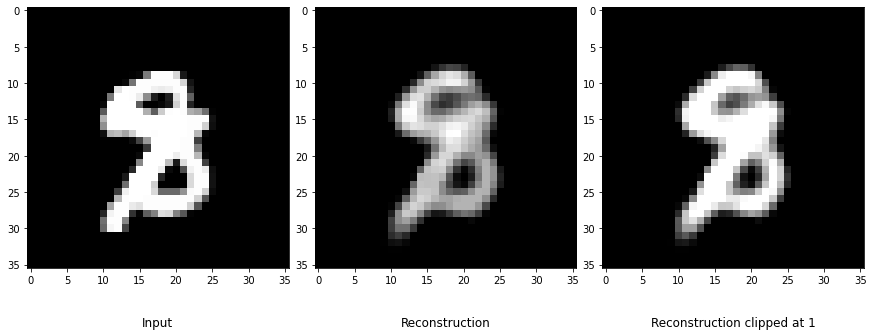

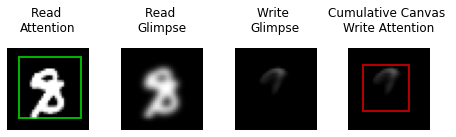

tensor([0.0172, 0.0641, 0.0409, 0.0619, 0.0206, 0.0194, 0.0415, 0.0841, 0.0256,
        0.0096])
tensor([7, 1, 3, 6, 2, 8, 4, 5, 0, 9])


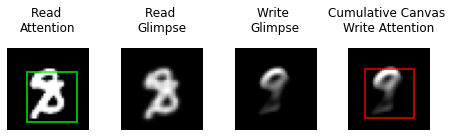

tensor([0.0264, 0.0406, 0.0515, 0.0146, 0.0711, 0.0188, 0.0224, 0.2474, 0.3913,
        0.1553])
tensor([8, 7, 9, 4, 2, 1, 0, 6, 5, 3])


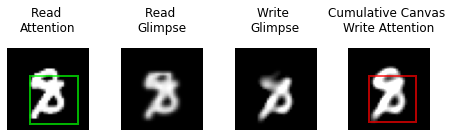

tensor([0.0422, 0.3412, 0.0237, 0.0464, 0.2022, 0.0385, 0.0954, 0.4368, 0.7232,
        0.2320])
tensor([8, 7, 1, 9, 4, 6, 3, 0, 5, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0857, 0.4459, 0.1161, 0.1229, 0.2939, 0.0766, 0.1593, 0.7684, 1.1401,
        0.3969], device='cuda:0')
tensor([8, 7, 1, 9, 4, 6, 3, 2, 0, 5], device='cuda:0')

****************************************************************************************************
trial 8

ground truth
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])
tensor([6, 7])
model prediction
tensor([0.1029, 0.0743, 0.0880, 0.0301, 0.0600, 0.1099, 0.8923, 1.0000, 0.0602,
        0.0627])
tensor([False, False, False, False, False, False,  True,  True, False, False])
tensor([6, 7])
partial score, 1.0, exact score, True


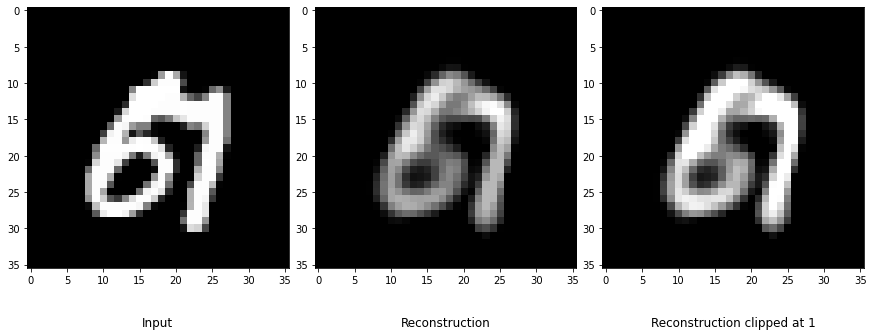

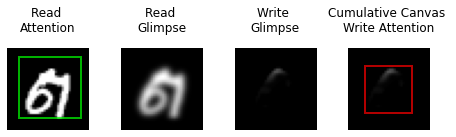

tensor([0.0621, 0.0557, 0.0421, 0.0084, 0.0294, 0.0382, 0.0933, 0.0673, 0.0302,
        0.0131])
tensor([6, 7, 0, 1, 2, 5, 8, 4, 9, 3])


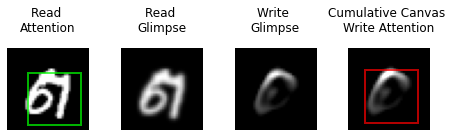

tensor([0.0114, 0.0139, 0.0398, 0.0102, 0.0088, 0.0369, 0.4232, 0.4540, 0.0146,
        0.0358])
tensor([7, 6, 2, 5, 9, 8, 1, 0, 3, 4])


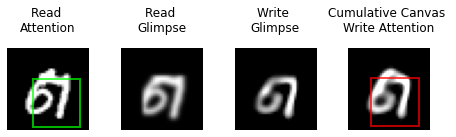

tensor([0.0527, 0.0214, 0.0259, 0.0183, 0.0353, 0.0596, 0.5771, 0.7042, 0.0290,
        0.0280])
tensor([7, 6, 5, 0, 4, 8, 9, 2, 1, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.1262, 0.0910, 0.1079, 0.0369, 0.0735, 0.1347, 1.0936, 1.2256, 0.0738,
        0.0769], device='cuda:0')
tensor([7, 6, 5, 0, 2, 1, 9, 8, 4, 3], device='cuda:0')

****************************************************************************************************
trial 9

ground truth
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
tensor([7, 9])
model prediction
tensor([0.0454, 0.6651, 0.0903, 0.0603, 0.6451, 0.0426, 0.0557, 0.5918, 0.0702,
        1.0000])
tensor([False,  True, False, False, False, False, False, False, False,  True])
tensor([1, 9])
partial score, 0.5, exact score, False


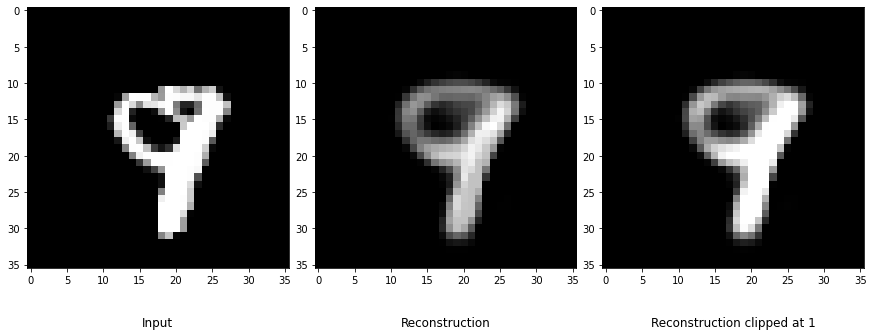

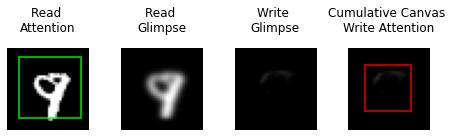

tensor([0.0218, 0.0621, 0.0403, 0.0322, 0.0160, 0.0183, 0.0186, 0.0717, 0.0090,
        0.0080])
tensor([7, 1, 2, 3, 0, 6, 5, 4, 8, 9])


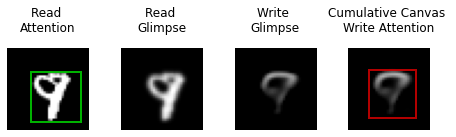

tensor([0.0076, 0.1123, 0.0299, 0.0107, 0.2021, 0.0106, 0.0198, 0.0920, 0.0141,
        0.2760])
tensor([9, 4, 1, 7, 2, 6, 8, 3, 5, 0])


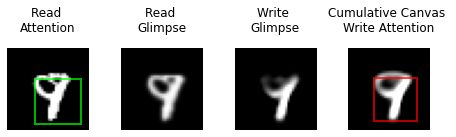

tensor([0.0094, 0.3928, 0.0068, 0.0086, 0.3321, 0.0075, 0.0091, 0.3411, 0.0367,
        0.5688])
tensor([9, 1, 7, 4, 8, 0, 6, 3, 5, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0388, 0.5672, 0.0770, 0.0514, 0.5502, 0.0364, 0.0475, 0.5048, 0.0598,
        0.8529], device='cuda:0')
tensor([9, 1, 4, 7, 2, 8, 3, 6, 0, 5], device='cuda:0')

****************************************************************************************************
trial 10

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 7])
model prediction
tensor([1.0000, 0.0970, 0.0920, 0.0609, 0.0561, 0.0424, 0.0489, 0.9000, 0.0508,
        0.0685])
tensor([ True, False, False, False, False, False, False,  True, False, False])
tensor([0, 7])
partial score, 1.0, exact score, True


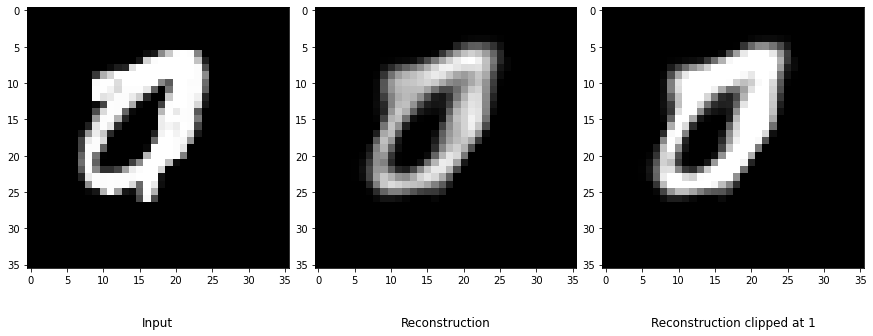

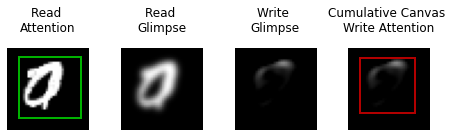

tensor([0.2058, 0.0540, 0.0414, 0.0195, 0.0154, 0.0096, 0.0290, 0.1825, 0.0324,
        0.0167])
tensor([0, 7, 1, 2, 8, 6, 3, 9, 4, 5])


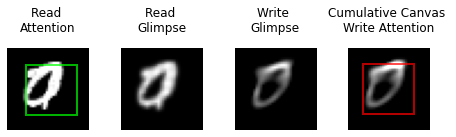

tensor([0.5911, 0.0461, 0.0449, 0.0389, 0.0300, 0.0264, 0.0257, 0.5472, 0.0263,
        0.0338])
tensor([0, 7, 1, 2, 3, 9, 4, 5, 8, 6])


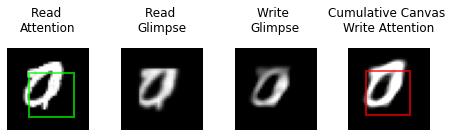

tensor([0.7539, 0.0502, 0.0564, 0.0360, 0.0416, 0.0297, 0.0212, 0.6660, 0.0200,
        0.0558])
tensor([0, 7, 2, 9, 1, 4, 3, 5, 6, 8])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.5508, 0.1504, 0.1427, 0.0945, 0.0870, 0.0657, 0.0759, 1.3957, 0.0788,
        0.1063], device='cuda:0')
tensor([0, 7, 1, 2, 9, 3, 4, 8, 6, 5], device='cuda:0')

****************************************************************************************************
trial 11

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
model prediction
tensor([0.0471, 0.0589, 0.0732, 1.0000, 0.1629, 0.0750, 0.0713, 0.0536, 0.0693,
        0.9653])
tensor([False, False, False,  True, False, False, False, False, False,  True])
tensor([3, 9])
partial score, 1.0, exact score, True


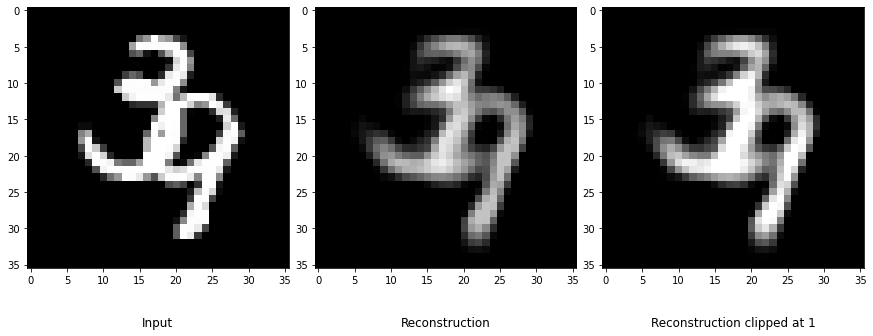

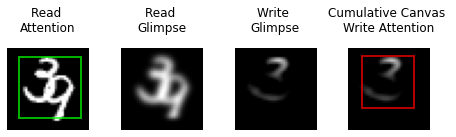

tensor([0.0172, 0.0363, 0.0269, 0.3196, 0.0458, 0.0241, 0.0547, 0.0288, 0.0352,
        0.0691])
tensor([3, 9, 6, 4, 1, 8, 7, 2, 5, 0])


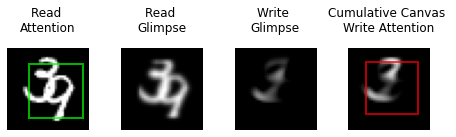

tensor([0.0235, 0.0249, 0.0461, 0.5610, 0.0643, 0.0576, 0.0222, 0.0253, 0.0291,
        0.3500])
tensor([3, 9, 4, 5, 2, 8, 7, 1, 0, 6])


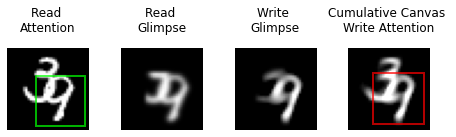

tensor([0.0143, 0.0075, 0.0123, 0.2847, 0.0798, 0.0057, 0.0062, 0.0084, 0.0165,
        0.7057])
tensor([9, 3, 4, 8, 0, 2, 7, 1, 6, 5])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0549, 0.0686, 0.0854, 1.1653, 0.1899, 0.0874, 0.0831, 0.0625, 0.0807,
        1.1249], device='cuda:0')
tensor([3, 9, 4, 5, 2, 6, 8, 1, 7, 0], device='cuda:0')

****************************************************************************************************
trial 12

ground truth
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
tensor([2, 9])
model prediction
tensor([0.0363, 0.0640, 1.0000, 0.0488, 0.0283, 0.1744, 0.0962, 0.0553, 0.0560,
        0.9080])
tensor([False, False,  True, False, False, False, False, False, False,  True])
tensor([2, 9])
partial score, 1.0, exact score, True


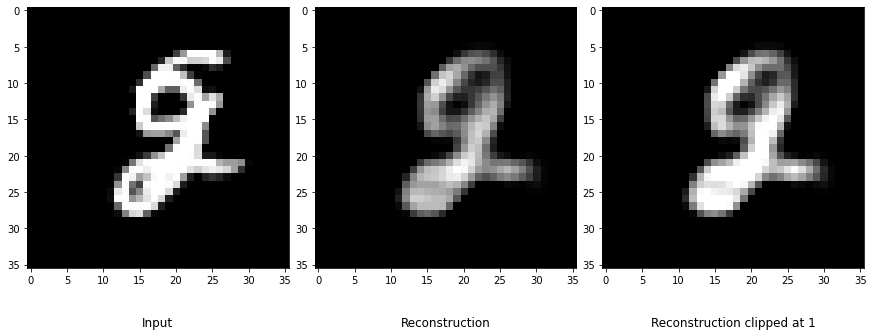

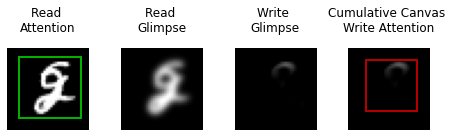

tensor([0.0181, 0.0495, 0.1200, 0.0220, 0.0067, 0.1048, 0.0848, 0.0440, 0.0140,
        0.0208])
tensor([2, 5, 6, 1, 7, 3, 9, 0, 8, 4])


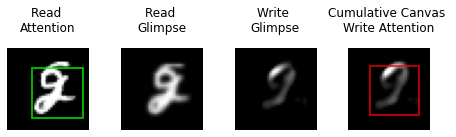

tensor([0.0118, 0.0161, 0.3871, 0.0103, 0.0113, 0.0721, 0.0101, 0.0117, 0.0240,
        0.3767])
tensor([2, 9, 5, 8, 1, 0, 7, 4, 3, 6])


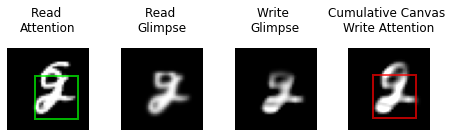

tensor([0.0139, 0.0116, 0.6996, 0.0266, 0.0161, 0.0334, 0.0212, 0.0110, 0.0296,
        0.6982])
tensor([2, 9, 5, 8, 3, 6, 4, 0, 1, 7])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0438, 0.0773, 1.2068, 0.0589, 0.0341, 0.2104, 0.1161, 0.0667, 0.0676,
        1.0958], device='cuda:0')
tensor([2, 9, 5, 6, 1, 8, 7, 3, 0, 4], device='cuda:0')

****************************************************************************************************
trial 13

ground truth
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 4])
model prediction
tensor([0.0509, 1.0000, 0.0767, 0.0359, 0.9204, 0.0926, 0.0970, 0.0454, 0.0543,
        0.1835])
tensor([False,  True, False, False,  True, False, False, False, False, False])
tensor([1, 4])
partial score, 1.0, exact score, True


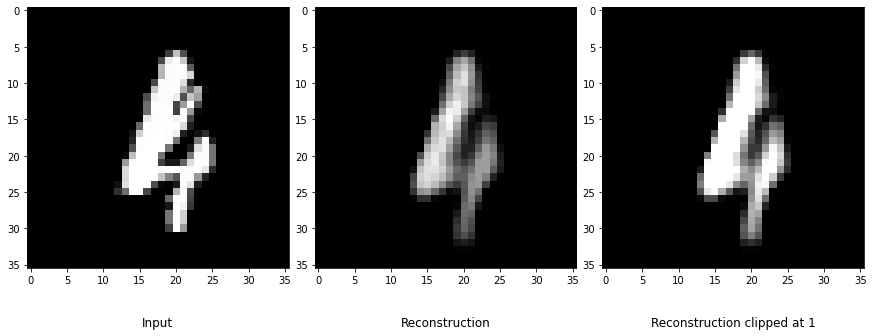

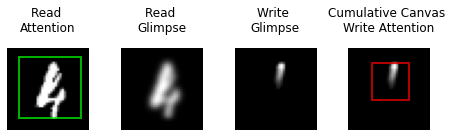

tensor([0.0110, 0.1498, 0.0280, 0.0236, 0.0118, 0.0139, 0.0594, 0.0199, 0.0151,
        0.0162])
tensor([1, 6, 2, 3, 7, 9, 8, 5, 4, 0])


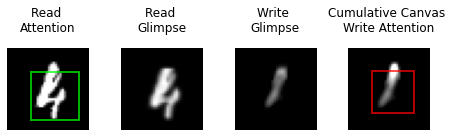

tensor([0.0127, 0.4169, 0.0392, 0.0154, 0.3617, 0.0756, 0.0215, 0.0155, 0.0211,
        0.1232])
tensor([1, 4, 9, 5, 2, 6, 8, 7, 3, 0])


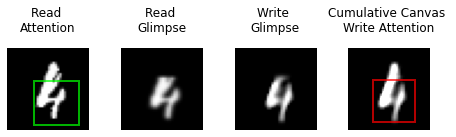

tensor([0.0378, 0.6422, 0.0255, 0.0044, 0.7391, 0.0224, 0.0364, 0.0195, 0.0295,
        0.0824])
tensor([4, 1, 9, 0, 6, 8, 2, 5, 7, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0615, 1.2089, 0.0927, 0.0434, 1.1126, 0.1119, 0.1173, 0.0548, 0.0657,
        0.2218], device='cuda:0')
tensor([1, 4, 9, 6, 5, 2, 8, 0, 7, 3], device='cuda:0')

****************************************************************************************************
trial 14

ground truth
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])
tensor([4, 9])
model prediction
tensor([0.0934, 0.0852, 0.1571, 0.1013, 1.0000, 0.0862, 0.0885, 0.3195, 0.0491,
        0.5586])
tensor([False, False, False, False,  True, False, False, False, False,  True])
tensor([4, 9])
partial score, 1.0, exact score, True


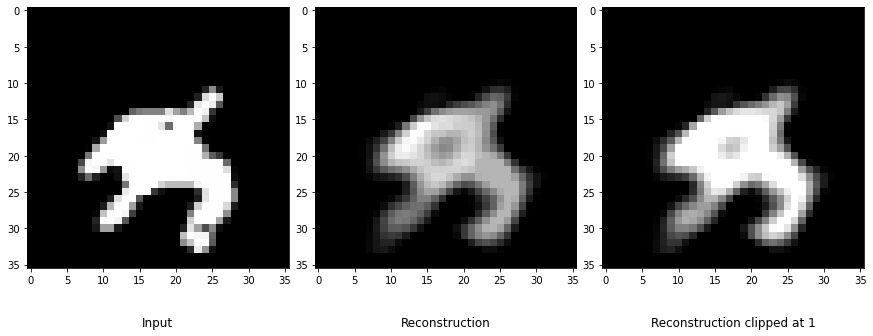

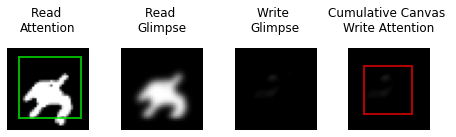

tensor([0.0421, 0.0809, 0.0802, 0.0421, 0.0316, 0.0198, 0.0752, 0.0854, 0.0162,
        0.0202])
tensor([7, 1, 2, 6, 0, 3, 4, 9, 5, 8])


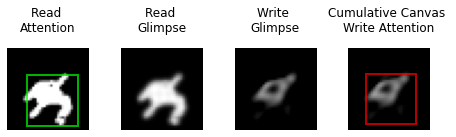

tensor([0.0541, 0.0099, 0.0808, 0.0471, 0.4289, 0.0338, 0.0142, 0.0396, 0.0304,
        0.2174])
tensor([4, 9, 2, 0, 3, 7, 5, 8, 6, 1])


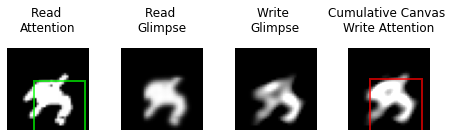

tensor([0.0119, 0.0079, 0.0210, 0.0282, 0.6974, 0.0462, 0.0130, 0.2449, 0.0103,
        0.4091])
tensor([4, 9, 7, 5, 3, 2, 6, 0, 8, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.1081, 0.0987, 0.1819, 0.1173, 1.1579, 0.0998, 0.1025, 0.3699, 0.0569,
        0.6468], device='cuda:0')
tensor([4, 9, 7, 2, 3, 0, 6, 5, 1, 8], device='cuda:0')

****************************************************************************************************
trial 15

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 7])
model prediction
tensor([1.0000, 0.0399, 0.0872, 0.0701, 0.0626, 0.0413, 0.0398, 0.9872, 0.0747,
        0.0611])
tensor([ True, False, False, False, False, False, False,  True, False, False])
tensor([0, 7])
partial score, 1.0, exact score, True


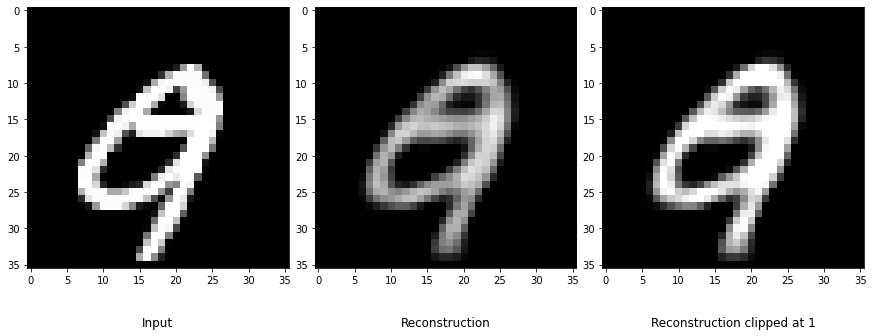

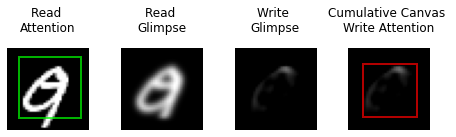

tensor([0.1337, 0.0282, 0.0442, 0.0362, 0.0399, 0.0207, 0.0289, 0.0730, 0.0517,
        0.0233])
tensor([0, 7, 8, 2, 4, 3, 6, 1, 9, 5])


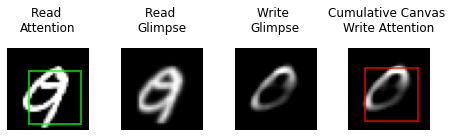

tensor([0.5089, 0.0064, 0.0237, 0.0102, 0.0104, 0.0078, 0.0053, 0.3930, 0.0239,
        0.0312])
tensor([0, 7, 9, 8, 2, 4, 3, 5, 1, 6])


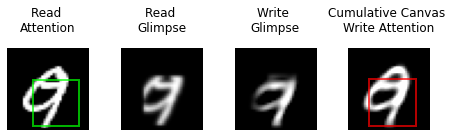

tensor([0.5997, 0.0149, 0.0404, 0.0407, 0.0275, 0.0228, 0.0152, 0.7605, 0.0172,
        0.0214])
tensor([7, 0, 3, 2, 4, 5, 9, 8, 6, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.2424, 0.0495, 0.1083, 0.0871, 0.0778, 0.0513, 0.0494, 1.2265, 0.0928,
        0.0759], device='cuda:0')
tensor([0, 7, 2, 8, 3, 4, 9, 5, 1, 6], device='cuda:0')

****************************************************************************************************
trial 16

ground truth
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])
tensor([6, 7])
model prediction
tensor([0.0748, 0.0913, 0.0696, 0.0460, 0.0675, 0.0569, 1.0000, 0.9786, 0.0359,
        0.0783])
tensor([False, False, False, False, False, False,  True,  True, False, False])
tensor([6, 7])
partial score, 1.0, exact score, True


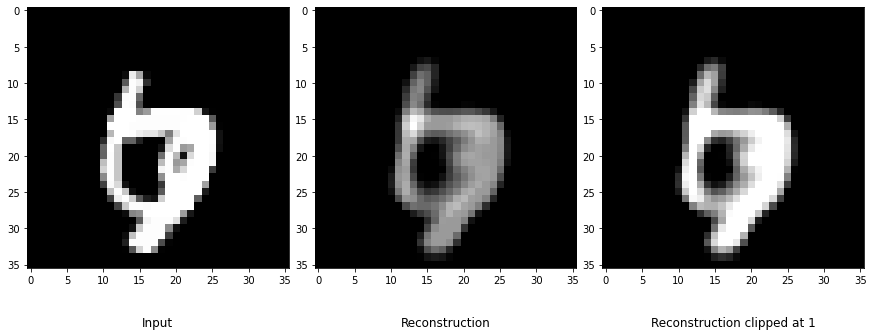

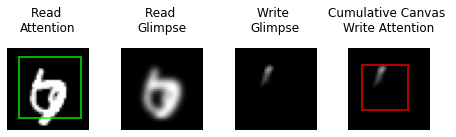

tensor([0.0410, 0.0672, 0.0198, 0.0090, 0.0312, 0.0201, 0.1254, 0.0623, 0.0123,
        0.0129])
tensor([6, 1, 7, 0, 4, 5, 2, 9, 8, 3])


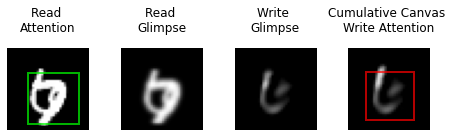

tensor([0.0100, 0.0121, 0.0230, 0.0222, 0.0291, 0.0121, 0.2543, 0.2308, 0.0096,
        0.0312])
tensor([6, 7, 9, 4, 2, 3, 1, 5, 0, 8])


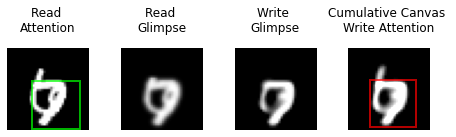

tensor([0.0254, 0.0140, 0.0283, 0.0158, 0.0087, 0.0259, 0.6419, 0.7067, 0.0148,
        0.0358])
tensor([7, 6, 9, 2, 5, 0, 3, 8, 1, 4])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0764, 0.0932, 0.0711, 0.0470, 0.0690, 0.0581, 1.0217, 0.9998, 0.0367,
        0.0800], device='cuda:0')
tensor([6, 7, 1, 9, 0, 2, 4, 5, 3, 8], device='cuda:0')

****************************************************************************************************
trial 17

ground truth
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
tensor([1, 3])
model prediction
tensor([0.0260, 1.0000, 0.0412, 0.9173, 0.0523, 0.0490, 0.0362, 0.0532, 0.0560,
        0.0487])
tensor([False,  True, False,  True, False, False, False, False, False, False])
tensor([1, 3])
partial score, 1.0, exact score, True


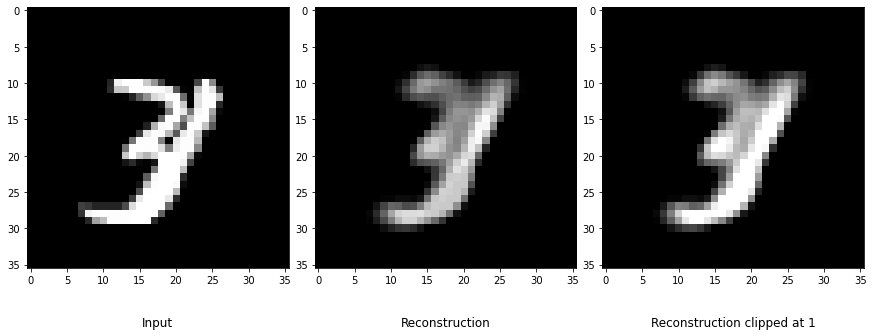

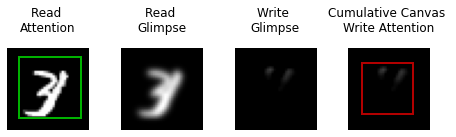

tensor([0.0087, 0.0740, 0.0317, 0.0398, 0.0089, 0.0114, 0.0058, 0.0488, 0.0041,
        0.0084])
tensor([1, 7, 3, 2, 5, 4, 0, 9, 6, 8])


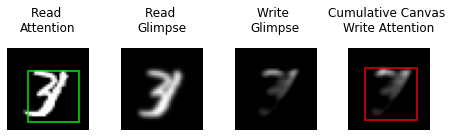

tensor([0.0105, 0.5503, 0.0104, 0.4706, 0.0108, 0.0137, 0.0183, 0.0072, 0.0143,
        0.0293])
tensor([1, 3, 9, 6, 8, 5, 4, 0, 2, 7])


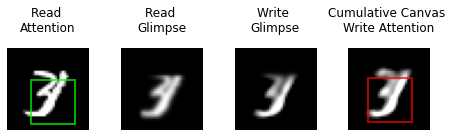

tensor([0.0156, 0.7119, 0.0130, 0.7154, 0.0502, 0.0405, 0.0244, 0.0150, 0.0564,
        0.0274])
tensor([3, 1, 8, 4, 5, 9, 6, 0, 7, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0348, 1.3363, 0.0551, 1.2258, 0.0699, 0.0655, 0.0484, 0.0710, 0.0748,
        0.0651], device='cuda:0')
tensor([1, 3, 8, 7, 4, 5, 9, 2, 6, 0], device='cuda:0')

****************************************************************************************************
trial 18

ground truth
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1])
model prediction
tensor([0.7156, 1.0000, 0.1137, 0.0341, 0.0677, 0.0587, 0.5040, 0.1899, 0.0505,
        0.1255])
tensor([ True,  True, False, False, False, False, False, False, False, False])
tensor([0, 1])
partial score, 1.0, exact score, True


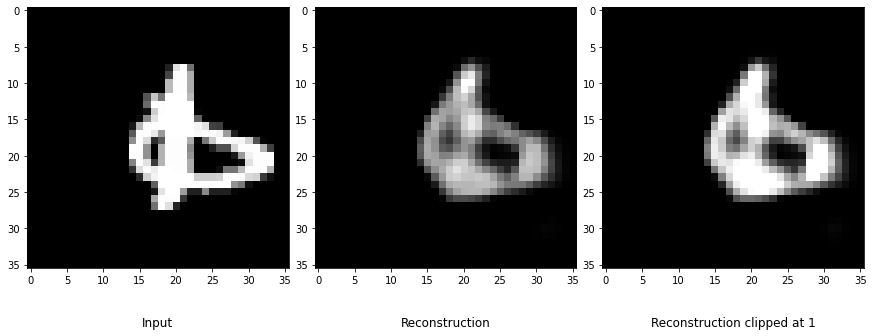

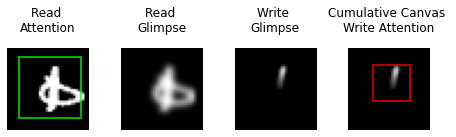

tensor([0.0091, 0.1595, 0.0859, 0.0175, 0.0246, 0.0182, 0.0806, 0.0649, 0.0147,
        0.0126])
tensor([1, 2, 6, 7, 4, 5, 3, 8, 9, 0])


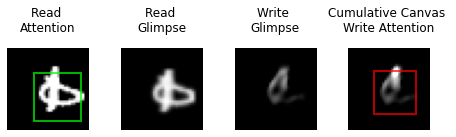

tensor([0.2332, 0.4658, 0.0206, 0.0134, 0.0305, 0.0224, 0.2395, 0.0413, 0.0181,
        0.0434])
tensor([1, 6, 0, 9, 7, 4, 5, 2, 8, 3])


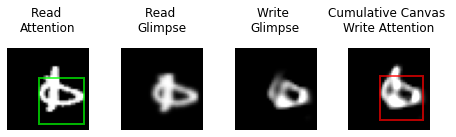

tensor([0.6265, 0.5890, 0.0316, 0.0105, 0.0271, 0.0306, 0.2918, 0.1243, 0.0286,
        0.0965])
tensor([0, 1, 6, 7, 9, 2, 5, 8, 4, 3])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.8689, 1.2142, 0.1381, 0.0414, 0.0822, 0.0713, 0.6119, 0.2305, 0.0614,
        0.1524], device='cuda:0')
tensor([1, 0, 6, 7, 9, 2, 4, 5, 8, 3], device='cuda:0')

****************************************************************************************************
trial 19

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
model prediction
tensor([0.0340, 0.0634, 0.0695, 1.0000, 0.4143, 0.0326, 0.0789, 0.1108, 0.0610,
        0.8762])
tensor([False, False, False,  True, False, False, False, False, False,  True])
tensor([3, 9])
partial score, 1.0, exact score, True


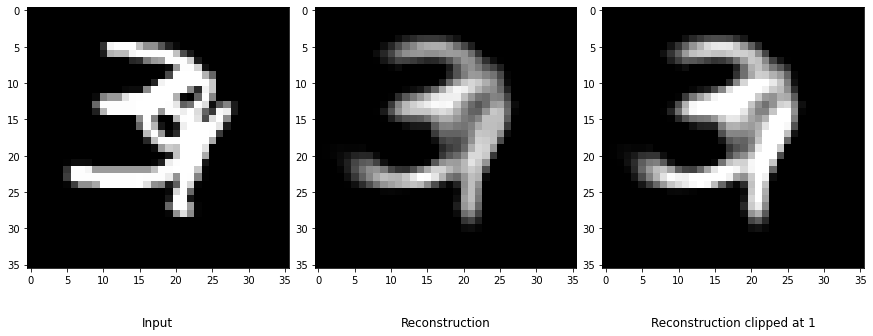

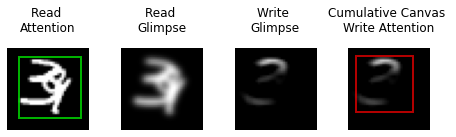

tensor([0.0191, 0.0696, 0.0407, 0.3671, 0.1113, 0.0158, 0.0762, 0.1088, 0.0430,
        0.0732])
tensor([3, 4, 7, 6, 9, 1, 8, 2, 0, 5])


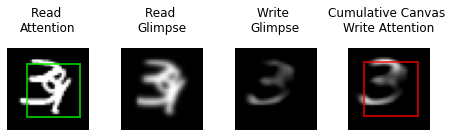

tensor([0.0107, 0.0078, 0.0234, 0.5681, 0.2343, 0.0185, 0.0357, 0.0327, 0.0356,
        0.5500])
tensor([3, 9, 4, 6, 8, 7, 2, 5, 0, 1])


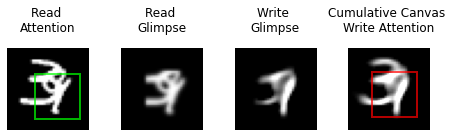

tensor([0.0219, 0.0190, 0.0416, 0.5856, 0.2845, 0.0153, 0.0082, 0.0271, 0.0141,
        0.7094])
tensor([9, 3, 4, 2, 7, 0, 1, 5, 8, 6])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0518, 0.0964, 0.1057, 1.5208, 0.6301, 0.0496, 0.1200, 0.1686, 0.0927,
        1.3326], device='cuda:0')
tensor([3, 9, 4, 7, 6, 2, 1, 8, 0, 5], device='cuda:0')

****************************************************************************************************
trial 20

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 8])
model prediction
tensor([0.0704, 0.9057, 0.0928, 0.0376, 0.0916, 0.0527, 0.0472, 0.2686, 1.0000,
        0.0576])
tensor([False,  True, False, False, False, False, False, False,  True, False])
tensor([1, 8])
partial score, 1.0, exact score, True


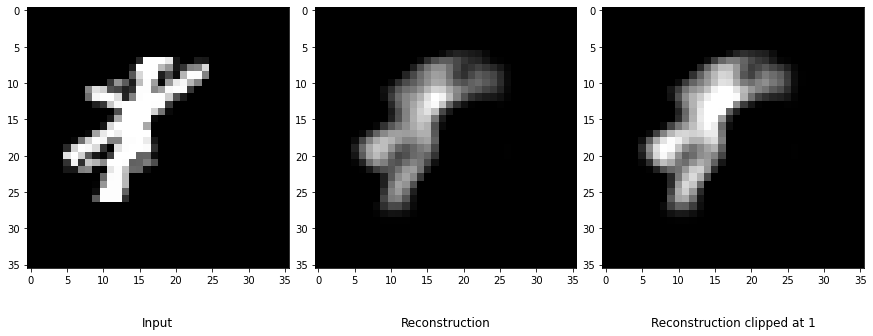

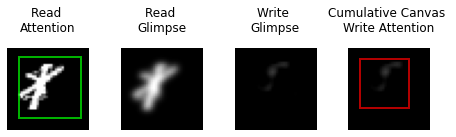

tensor([0.0727, 0.2404, 0.1059, 0.0191, 0.0783, 0.0421, 0.0415, 0.1008, 0.1797,
        0.0185])
tensor([1, 8, 2, 7, 4, 0, 5, 6, 3, 9])


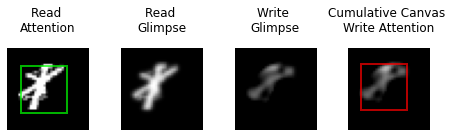

tensor([0.0103, 0.4505, 0.0139, 0.0182, 0.0428, 0.0090, 0.0063, 0.1306, 0.6468,
        0.0293])
tensor([8, 1, 7, 4, 9, 3, 2, 0, 5, 6])


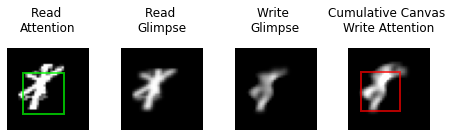

tensor([0.0224, 0.6666, 0.0192, 0.0191, 0.0163, 0.0279, 0.0230, 0.1712, 0.6723,
        0.0385])
tensor([8, 1, 7, 9, 5, 6, 0, 2, 3, 4])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.1055, 1.3575, 0.1390, 0.0563, 0.1373, 0.0790, 0.0707, 0.4026, 1.4988,
        0.0863], device='cuda:0')
tensor([8, 1, 7, 2, 4, 0, 9, 5, 6, 3], device='cuda:0')

****************************************************************************************************
trial 21

ground truth
tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 4])
model prediction
tensor([0.0448, 0.7933, 0.0889, 0.0558, 1.0000, 0.0723, 0.2568, 0.0659, 0.0745,
        0.0740])
tensor([False,  True, False, False,  True, False, False, False, False, False])
tensor([1, 4])
partial score, 1.0, exact score, True


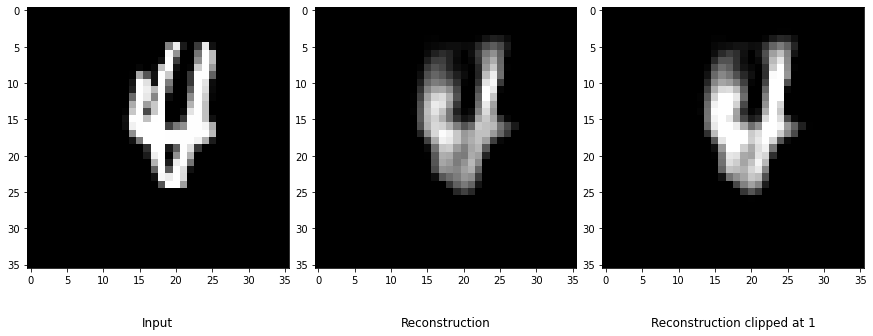

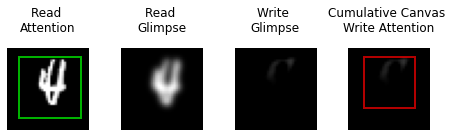

tensor([0.0155, 0.1040, 0.0863, 0.0518, 0.1536, 0.0609, 0.1283, 0.0280, 0.0478,
        0.0628])
tensor([4, 6, 1, 2, 9, 5, 3, 8, 7, 0])


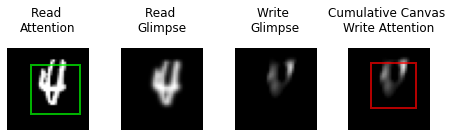

tensor([0.0375, 0.3453, 0.0199, 0.0082, 0.5400, 0.0138, 0.1674, 0.0404, 0.0457,
        0.0236])
tensor([4, 1, 6, 8, 7, 0, 9, 2, 5, 3])


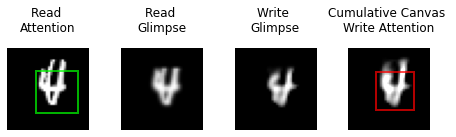

tensor([0.0127, 0.7137, 0.0241, 0.0217, 0.7725, 0.0313, 0.0808, 0.0281, 0.0156,
        0.0221])
tensor([4, 1, 6, 5, 7, 2, 9, 3, 8, 0])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0657, 1.1631, 0.1303, 0.0818, 1.4661, 0.1060, 0.3765, 0.0966, 0.1092,
        0.1086], device='cuda:0')
tensor([4, 1, 6, 2, 8, 9, 5, 7, 3, 0], device='cuda:0')

****************************************************************************************************
trial 22

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 8])
model prediction
tensor([0.0705, 0.8023, 0.1229, 0.0931, 0.1740, 0.1134, 0.1150, 0.1122, 1.0000,
        0.1236])
tensor([False,  True, False, False, False, False, False, False,  True, False])
tensor([1, 8])
partial score, 1.0, exact score, True


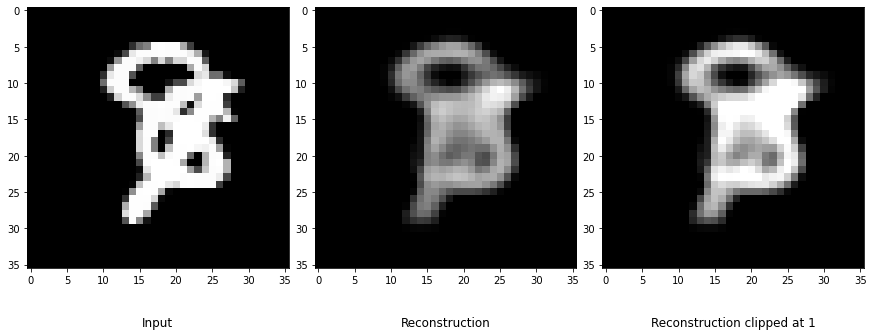

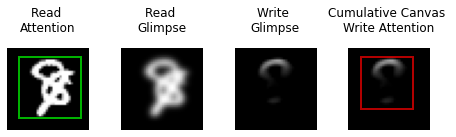

tensor([0.0542, 0.0821, 0.0945, 0.0653, 0.0506, 0.1080, 0.1048, 0.0732, 0.1525,
        0.0780])
tensor([8, 5, 6, 2, 1, 9, 7, 3, 0, 4])


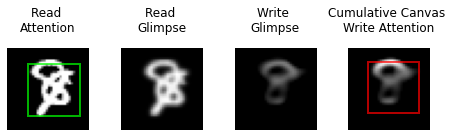

tensor([0.0103, 0.3396, 0.0243, 0.0198, 0.0217, 0.0196, 0.0253, 0.0651, 0.5585,
        0.0422])
tensor([8, 1, 7, 9, 6, 2, 4, 3, 5, 0])


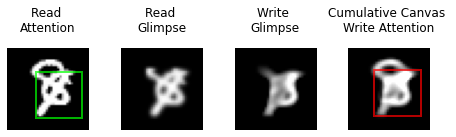

tensor([0.0402, 0.7692, 0.0636, 0.0532, 0.1860, 0.0408, 0.0407, 0.0283, 0.7734,
        0.0632])
tensor([8, 1, 4, 2, 9, 3, 5, 6, 0, 7])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.1047, 1.1909, 0.1824, 0.1383, 0.2583, 0.1684, 0.1707, 0.1665, 1.4844,
        0.1834], device='cuda:0')
tensor([8, 1, 4, 9, 2, 6, 5, 7, 3, 0], device='cuda:0')

****************************************************************************************************
trial 23

ground truth
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
tensor([7, 9])
model prediction
tensor([0.0328, 0.0545, 0.0575, 0.0338, 0.1061, 0.0226, 0.0449, 1.0000, 0.0405,
        0.8272])
tensor([False, False, False, False, False, False, False,  True, False,  True])
tensor([7, 9])
partial score, 1.0, exact score, True


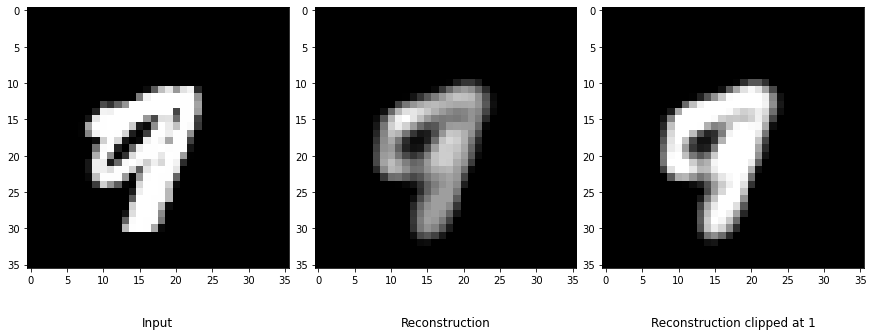

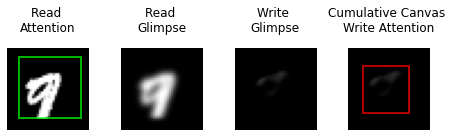

tensor([0.0168, 0.0582, 0.0572, 0.0218, 0.0196, 0.0105, 0.0339, 0.1073, 0.0162,
        0.0076])
tensor([7, 1, 2, 6, 3, 4, 0, 8, 5, 9])


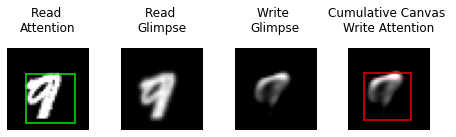

tensor([0.0033, 0.0030, 0.0049, 0.0063, 0.0835, 0.0052, 0.0049, 0.3640, 0.0104,
        0.3461])
tensor([7, 9, 4, 8, 3, 5, 6, 2, 0, 1])


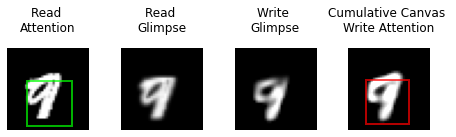

tensor([0.0197, 0.0051, 0.0078, 0.0130, 0.0258, 0.0117, 0.0156, 0.7435, 0.0225,
        0.6512])
tensor([7, 9, 4, 8, 0, 6, 3, 5, 2, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0398, 0.0662, 0.0699, 0.0411, 0.1289, 0.0274, 0.0545, 1.2148, 0.0492,
        1.0049], device='cuda:0')
tensor([7, 9, 4, 2, 1, 6, 8, 3, 0, 5], device='cuda:0')

****************************************************************************************************
trial 24

ground truth
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 8])
model prediction
tensor([0.9082, 0.0715, 0.2499, 0.0497, 0.0998, 0.0838, 0.1315, 0.1264, 1.0000,
        0.0494])
tensor([ True, False, False, False, False, False, False, False,  True, False])
tensor([0, 8])
partial score, 1.0, exact score, True


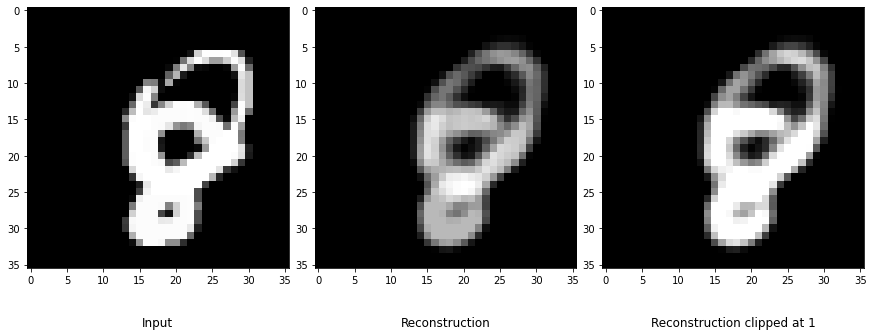

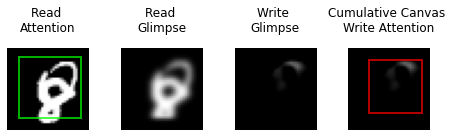

tensor([0.1001, 0.0701, 0.1354, 0.0317, 0.0829, 0.0572, 0.1347, 0.0709, 0.0589,
        0.0186])
tensor([2, 6, 0, 4, 7, 1, 8, 5, 3, 9])


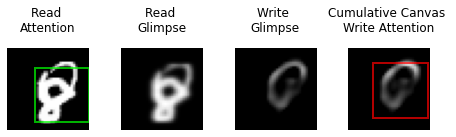

tensor([0.4624, 0.0048, 0.0893, 0.0116, 0.0158, 0.0124, 0.0084, 0.0361, 0.3419,
        0.0161])
tensor([0, 8, 2, 7, 9, 4, 5, 3, 6, 1])


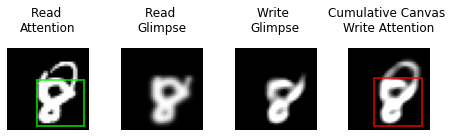

tensor([0.5115, 0.0096, 0.0708, 0.0155, 0.0193, 0.0296, 0.0124, 0.0425, 0.7817,
        0.0237])
tensor([8, 0, 2, 7, 5, 9, 4, 3, 6, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.0739, 0.0846, 0.2955, 0.0588, 0.1180, 0.0991, 0.1555, 0.1495, 1.1825,
        0.0584], device='cuda:0')
tensor([8, 0, 2, 6, 7, 4, 5, 1, 3, 9], device='cuda:0')

****************************************************************************************************
trial 25

ground truth
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 7])
model prediction
tensor([0.0473, 1.0000, 0.1225, 0.1495, 0.0555, 0.0806, 0.0694, 0.9986, 0.0728,
        0.0496])
tensor([False,  True, False, False, False, False, False,  True, False, False])
tensor([1, 7])
partial score, 1.0, exact score, True


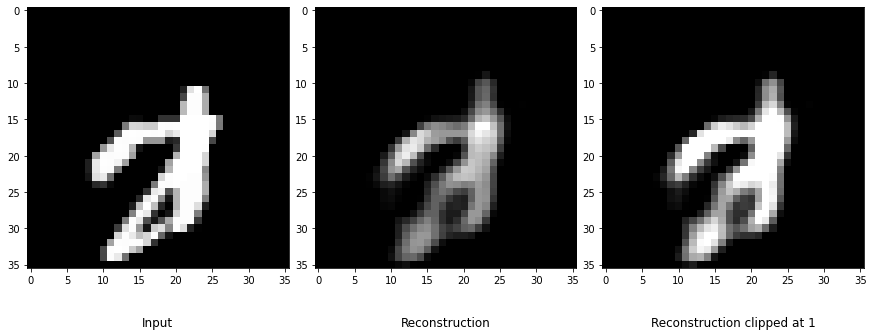

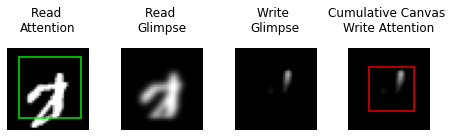

tensor([0.0136, 0.1873, 0.0755, 0.0218, 0.0185, 0.0054, 0.0412, 0.0763, 0.0075,
        0.0085])
tensor([1, 7, 2, 6, 3, 4, 0, 9, 8, 5])


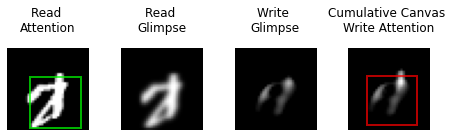

tensor([0.0310, 0.3082, 0.0352, 0.1282, 0.0295, 0.0717, 0.0241, 0.2814, 0.0586,
        0.0344])
tensor([1, 7, 3, 5, 8, 2, 9, 0, 4, 6])


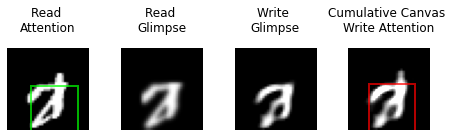

tensor([0.0064, 0.5813, 0.0212, 0.0109, 0.0117, 0.0097, 0.0095, 0.7176, 0.0122,
        0.0106])
tensor([7, 1, 2, 8, 4, 3, 9, 5, 6, 0])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0509, 1.0768, 0.1319, 0.1609, 0.0598, 0.0868, 0.0748, 1.0753, 0.0784,
        0.0535], device='cuda:0')
tensor([1, 7, 3, 2, 5, 8, 6, 4, 9, 0], device='cuda:0')

****************************************************************************************************
trial 26

ground truth
tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 4])
model prediction
tensor([0.9606, 0.0987, 0.0882, 0.0380, 1.0000, 0.0700, 0.0831, 0.1030, 0.0462,
        0.0455])
tensor([ True, False, False, False,  True, False, False, False, False, False])
tensor([0, 4])
partial score, 1.0, exact score, True


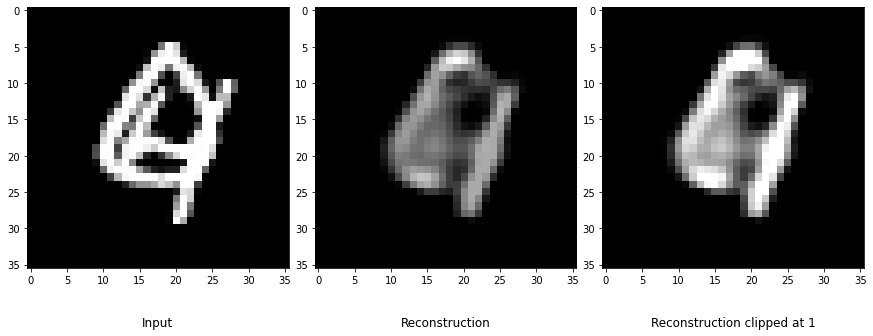

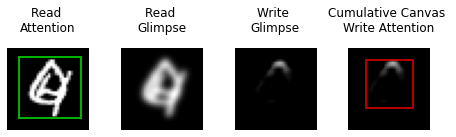

tensor([0.0870, 0.0262, 0.0549, 0.0171, 0.0133, 0.0260, 0.0828, 0.0432, 0.0272,
        0.0183])
tensor([0, 6, 2, 7, 8, 1, 5, 9, 3, 4])


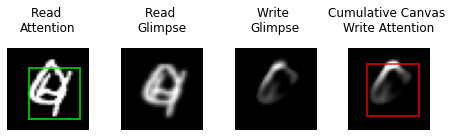

tensor([0.5515, 0.0229, 0.0187, 0.0096, 0.6024, 0.0135, 0.0127, 0.0278, 0.0191,
        0.0181])
tensor([4, 0, 7, 1, 8, 2, 9, 5, 6, 3])


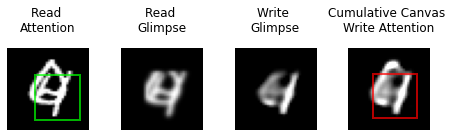

tensor([0.7533, 0.0938, 0.0543, 0.0284, 0.8332, 0.0619, 0.0249, 0.0783, 0.0206,
        0.0295])
tensor([4, 0, 1, 7, 5, 2, 9, 3, 6, 8])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.3918, 0.1430, 0.1279, 0.0551, 1.4489, 0.1015, 0.1204, 0.1493, 0.0669,
        0.0660], device='cuda:0')
tensor([4, 0, 7, 1, 2, 6, 5, 8, 9, 3], device='cuda:0')

****************************************************************************************************
trial 27

ground truth
tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])
tensor([6, 8])
model prediction
tensor([0.0823, 0.1195, 0.0915, 0.1132, 0.1013, 0.0647, 0.9287, 0.5451, 1.0000,
        0.1309])
tensor([False, False, False, False, False, False,  True, False,  True, False])
tensor([6, 8])
partial score, 1.0, exact score, True


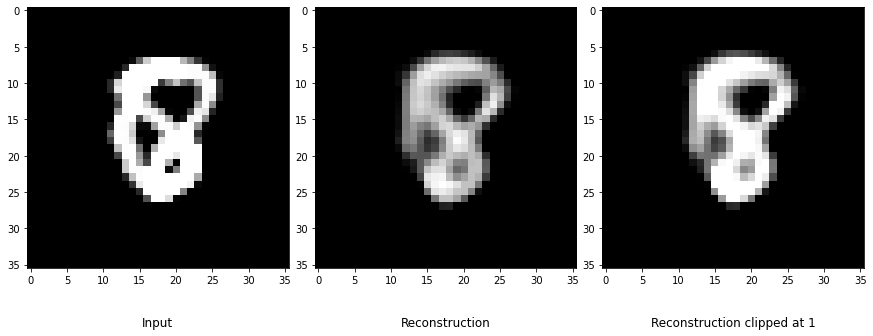

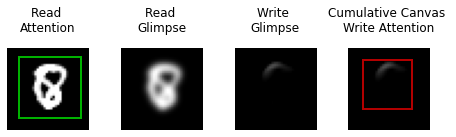

tensor([0.0267, 0.0426, 0.0246, 0.0219, 0.0349, 0.0112, 0.0630, 0.0361, 0.0251,
        0.0360])
tensor([6, 1, 7, 9, 4, 0, 8, 2, 3, 5])


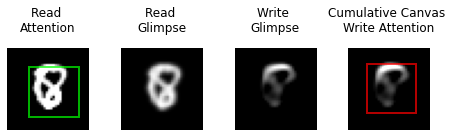

tensor([0.0471, 0.0542, 0.0652, 0.0804, 0.0397, 0.0269, 0.3373, 0.2961, 0.4111,
        0.0733])
tensor([8, 6, 7, 3, 9, 2, 1, 0, 4, 5])


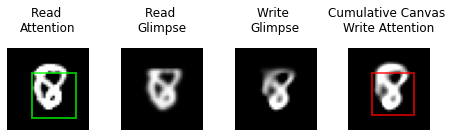

tensor([0.0130, 0.0292, 0.0068, 0.0171, 0.0324, 0.0302, 0.5798, 0.2431, 0.6191,
        0.0288])
tensor([8, 6, 7, 4, 5, 1, 9, 3, 0, 2])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0869, 0.1261, 0.0966, 0.1195, 0.1069, 0.0683, 0.9801, 0.5753, 1.0553,
        0.1381], device='cuda:0')
tensor([8, 6, 7, 9, 1, 3, 4, 2, 0, 5], device='cuda:0')

****************************************************************************************************
trial 28

ground truth
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1])
model prediction
tensor([0.9577, 1.0000, 0.1354, 0.0532, 0.0493, 0.0409, 0.1075, 0.0641, 0.0604,
        0.0457])
tensor([ True,  True, False, False, False, False, False, False, False, False])
tensor([0, 1])
partial score, 1.0, exact score, True


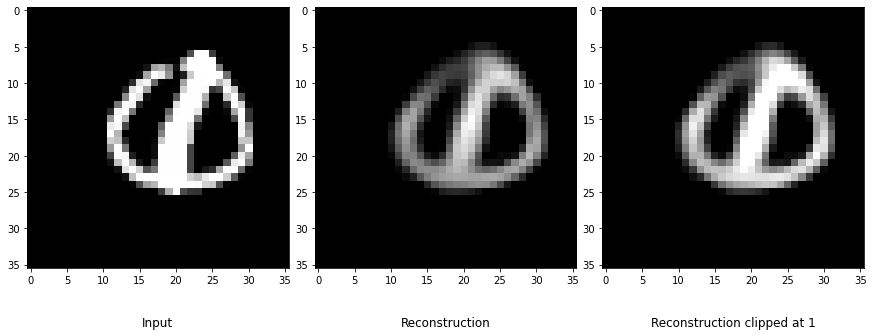

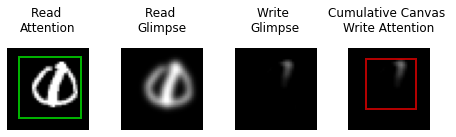

tensor([0.0417, 0.1038, 0.0710, 0.0152, 0.0242, 0.0125, 0.0638, 0.0246, 0.0134,
        0.0115])
tensor([1, 2, 6, 0, 7, 4, 3, 8, 5, 9])


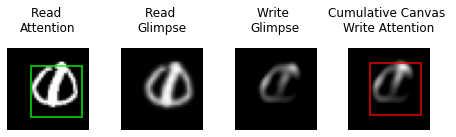

tensor([0.4031, 0.4018, 0.0628, 0.0177, 0.0080, 0.0187, 0.0385, 0.0204, 0.0350,
        0.0132])
tensor([0, 1, 2, 6, 8, 7, 5, 3, 9, 4])


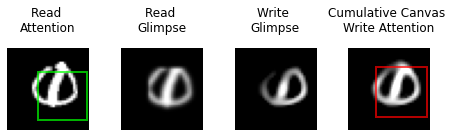

tensor([0.6839, 0.6730, 0.0257, 0.0297, 0.0259, 0.0170, 0.0243, 0.0305, 0.0228,
        0.0292])
tensor([0, 1, 7, 3, 9, 4, 2, 6, 8, 5])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([1.1288, 1.1787, 0.1595, 0.0627, 0.0582, 0.0482, 0.1266, 0.0755, 0.0712,
        0.0539], device='cuda:0')
tensor([1, 0, 2, 6, 7, 8, 3, 4, 9, 5], device='cuda:0')

****************************************************************************************************
trial 29

ground truth
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])
tensor([2, 8])
model prediction
tensor([0.0838, 0.0856, 1.0000, 0.0867, 0.0866, 0.0795, 0.0732, 0.0836, 0.9143,
        0.0472])
tensor([False, False,  True, False, False, False, False, False,  True, False])
tensor([2, 8])
partial score, 1.0, exact score, True


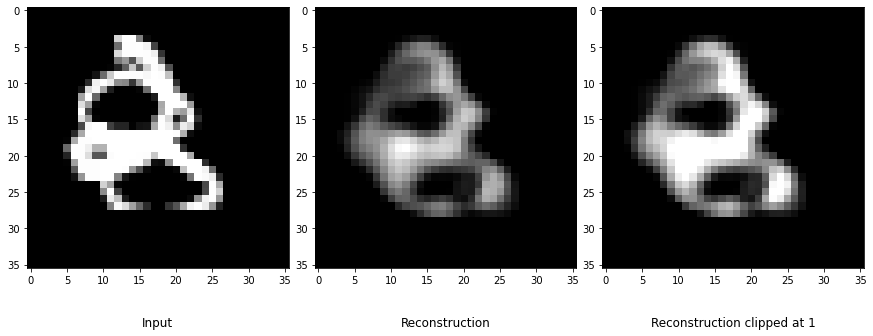

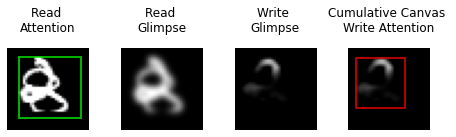

tensor([0.0680, 0.0759, 0.2685, 0.0544, 0.0457, 0.0450, 0.0623, 0.0638, 0.0556,
        0.0336])
tensor([2, 1, 0, 7, 6, 8, 3, 4, 5, 9])


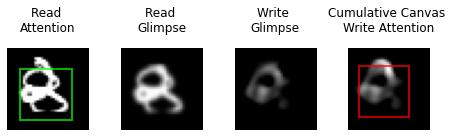

tensor([0.0294, 0.0138, 0.5335, 0.0186, 0.0453, 0.0193, 0.0147, 0.0332, 0.5497,
        0.0201])
tensor([8, 2, 4, 7, 0, 9, 5, 3, 6, 1])


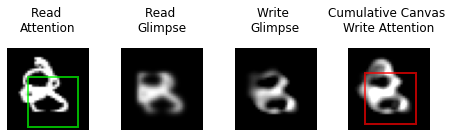

tensor([0.0214, 0.0316, 0.6154, 0.0498, 0.0317, 0.0485, 0.0268, 0.0215, 0.6907,
        0.0131])
tensor([8, 2, 3, 5, 4, 1, 6, 7, 0, 9])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.1188, 0.1213, 1.4175, 0.1228, 0.1227, 0.1127, 0.1038, 0.1186, 1.2960,
        0.0668], device='cuda:0')
tensor([2, 8, 3, 4, 1, 0, 7, 5, 6, 9], device='cuda:0')

****************************************************************************************************
trial 30

ground truth
tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
tensor([2, 5])
model prediction
tensor([0.0387, 0.0448, 1.0000, 0.0699, 0.0503, 0.9294, 0.0712, 0.0407, 0.1021,
        0.0590])
tensor([False, False,  True, False, False,  True, False, False, False, False])
tensor([2, 5])
partial score, 1.0, exact score, True


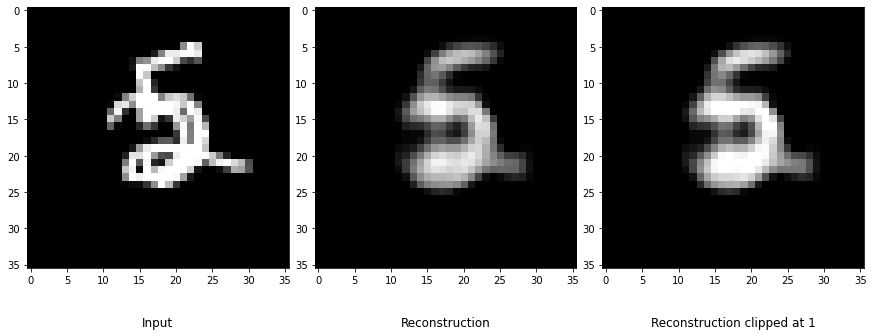

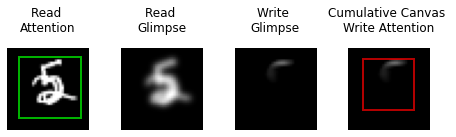

tensor([0.0137, 0.0212, 0.1030, 0.0233, 0.0216, 0.1095, 0.0584, 0.0113, 0.0138,
        0.0081])
tensor([5, 2, 6, 3, 4, 1, 8, 0, 7, 9])


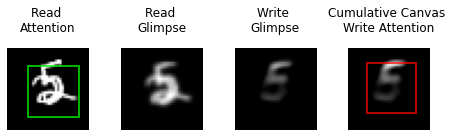

tensor([0.0221, 0.0300, 0.5987, 0.0477, 0.0338, 0.6449, 0.0205, 0.0235, 0.0624,
        0.0496])
tensor([5, 2, 8, 9, 3, 4, 1, 7, 0, 6])


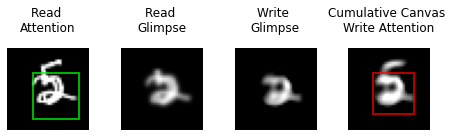

tensor([0.0196, 0.0129, 0.7288, 0.0290, 0.0166, 0.5751, 0.0228, 0.0233, 0.0698,
        0.0267])
tensor([2, 5, 8, 3, 9, 7, 6, 0, 4, 1])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0554, 0.0641, 1.4304, 0.1001, 0.0720, 1.3295, 0.1018, 0.0582, 0.1460,
        0.0844], device='cuda:0')
tensor([2, 5, 8, 6, 3, 9, 4, 1, 7, 0], device='cuda:0')

****************************************************************************************************
trial 31

ground truth
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])
tensor([3, 9])
model prediction
tensor([0.0723, 0.0903, 0.0565, 0.9270, 0.1064, 0.0924, 0.0720, 0.0895, 0.1287,
        1.0000])
tensor([False, False, False,  True, False, False, False, False, False,  True])
tensor([3, 9])
partial score, 1.0, exact score, True


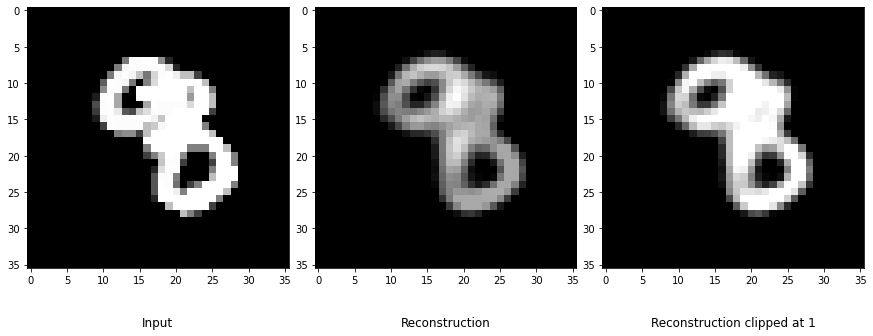

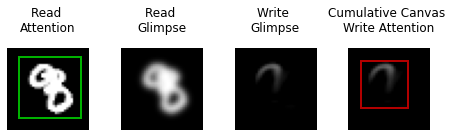

tensor([0.0440, 0.0925, 0.0448, 0.0388, 0.0665, 0.0394, 0.0778, 0.0803, 0.0669,
        0.0693])
tensor([1, 7, 6, 9, 8, 4, 2, 0, 5, 3])


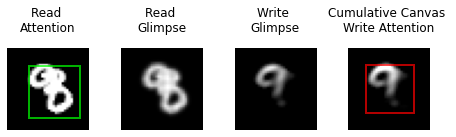

tensor([0.0375, 0.0179, 0.0156, 0.4378, 0.0151, 0.0748, 0.0121, 0.0202, 0.0812,
        0.5903])
tensor([9, 3, 8, 5, 0, 7, 1, 2, 4, 6])


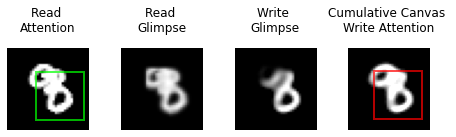

tensor([0.0164, 0.0119, 0.0161, 0.7785, 0.0623, 0.0109, 0.0076, 0.0207, 0.0262,
        0.6942])
tensor([3, 9, 4, 8, 7, 0, 2, 1, 5, 6])
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

tensor([0.0979, 0.1223, 0.0765, 1.2550, 0.1440, 0.1251, 0.0975, 0.1211, 0.1743,
        1.3538], device='cuda:0')
tensor([9, 3, 8, 4, 5, 1, 7, 0, 6, 2], device='cuda:0')


In [11]:
import matplotlib.gridspec as gridspec

num_trials = 32
idtrial_incorrect = []
save_plot = 1
create_gif = 1
fig_folder = args.output_dir + 'mm_3/'  # folder to save figs/gifs

if args.use_read_attn == False:
    args.read_size = args.image_dims[1]

if args.use_write_attn == False:
    args.write_size = args.image_dims[1]

y_pred_nars = y_pred.narrow(1,0,args.num_classes) 
y_pred_hots, _ , paccs , _, eaccs = cal_accs(y_pred_nars, y.to(args.device), readout_logits, args)

for i in range(num_trials): #len(y)):

    y_true = y[i].cpu()

    if torch.max(y_true) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_os = torch.squeeze(torch.nonzero(torch.squeeze(y_true)))
    else:
        y_os = torch.cat( (torch.nonzero(torch.squeeze(y_true))[0], torch.nonzero(torch.squeeze(y_true))[0]))

    y_pred_hot = y_pred_hots[i].cpu()
    y_pred_nar = y_pred_nars[i].cpu()
    if torch.max(y_pred_hot) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_pred_os = torch.squeeze(torch.nonzero(torch.squeeze(y_pred_hot)))
    else:
        y_pred_os = torch.cat( (torch.nonzero(torch.squeeze(y_pred_hot))[0], torch.nonzero(torch.squeeze(y_pred_hot))[0]))

    correct_partial = paccs[i].cpu()
    correct_exact = eaccs[i].cpu()

    # print only incorrect trials 
#     if correct_exact == 1:
#         continue 
#     idtrial_incorrect.append(i)
        
    print('\n' + '*'*100)
    print('trial ' + str(i))
        
    print('\nground truth')
    print(y_true)
    print(y_os)
    
    print('model prediction')
    print(y_pred_nar)
    print(y_pred_hot)
    print(y_pred_os)
        
    print(f'partial score, {correct_partial}, exact score, {correct_exact}')
    
        
    g_h = 1
    g_w = 3
    fig = plt.figure(figsize=(15,6))
    gs1 = gridspec.GridSpec(g_h, g_w)
    gs1.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    ax = plt.subplot(gs1[0,0])
    ax.imshow(torch.squeeze(x[i].movedim(0,-1)), cmap='gray')
    ax.text(0.5,-0.22,  "Input", size=12, ha="center", transform=ax.transAxes)

    ax = plt.subplot(gs1[0,1])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction", size=12, ha="center", transform=ax.transAxes)
    
    ax = plt.subplot(gs1[0,2])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), vmin=0, vmax=1, cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction clipped at 1", size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

    #--------------------------------------
    # plotting read and  write operatoins 
    
    
    for j in range(args.time_steps):
        
        g_h = 1
        g_w = 5
        fig = plt.figure(figsize=(10,1.5))
        gs1 = gridspec.GridSpec(g_h, g_w)
        gs1.update(wspace=0.1, hspace=0.1)

        class_l = torch.zeros((args.time_steps, args.num_classes+args.backg_objcaps))
    
        ax = plt.subplot(gs1[0,0])
        
#         if args.task == 'MultiMNIST_tracking':
#             print(x[i].shape)
#             x_t = x[i].narrow(0,j,1)
            
#         else:
        x_t = x[i]

        ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        
        ax.text(0.5,1.2,  "Read \nAttention", \
        size=12, ha="center", transform=ax.transAxes)
        
        #if args.use_glimpse_attn:
        if args.use_read_attn:
            mu_x = read_mu_xs[j][i]
            mu_y = read_mu_ys[j][i]

            r_x = mu_x[0]
            r_y = mu_y[0]
            r_w = mu_y[-1] - mu_y[0]
            r_h = mu_x[-1] - mu_x[0]

            ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))
            #-------------------------------------

#         if args.use_soft_attn:
#             p = j*step_num 
#             soft_map = att_param[p][7][i].cpu().numpy()
            
#             soft_map = np.reshape(soft_map, (8, 8))
#             plt.imshow(soft_map)
#             plt.show()
#             print(len(soft_map))
#             print(soft_map[0].shape)
#             break

            
        ax = plt.subplot(gs1[0,1])
        ax.imshow(read_x_step[i][j].movedim(0,-1).cpu(), cmap='gray')
        ax.axis('off')
        #if j==0:
        ax.text(0.5,1.2,  "Read \nGlimpse", \
        size=12, ha="center", transform=ax.transAxes)
            
        
        #---------------------------------------
        if args.recon_model:
            #im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), (args.image_dims[1],args.image_dims[2]))
            im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), \
                                (args.image_dims[0], args.image_dims[1],args.image_dims[2])).transpose(1,2,0)

            ax = plt.subplot(gs1[0,3])
            ax.imshow(im, vmin=0, vmax=1 , cmap='gray')  # max(np.max(im),1)
            ax.axis('off')

            #if j==0:
            ax.text(0.5,1.2,  "Cumulative Canvas \nWrite Attention", \
            size=12, ha="center", transform=ax.transAxes)
            
            if args.use_write_attn:
                mu_x = write_mu_xs[j][i]
                mu_y = write_mu_ys[j][i]

                w_x = mu_x[0]
                w_y = mu_y[0]
                w_w = mu_y[-1] - mu_y[0]
                w_h = mu_x[-1] - mu_x[0]

                ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))
                
                c_each = torch.clip(c_each, min=0, max=1)

                ax = plt.subplot(gs1[0,2])
                ax.imshow(c_each[i][j].movedim(0,-1).cpu(), vmin=0, vmax=1, cmap='gray')
                ax.axis('off')
                #if j==0:
                ax.text(0.5,1.2,  "Write \nGlimpse", \
                size=12, ha="center", transform=ax.transAxes)
        
#                 if args.task == 'MultiMNIST_tracking':
#                     x_t = x[i].narrow(0,j+1,1)
#                     ax = plt.subplot(gs1[j,5])
#                     ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
                        


        if save_plot:
            
            plt.margins(0,0)    
            save_folder = fig_folder + str(i) + '/'
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            fig.savefig( save_folder + 'image{:02d}'.format(j) + '.png', bbox_inches='tight', pad_inches=0.0)

        plt.show()
        
        class_l[j,:] = objcaps_len_step[i][j]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)

        print(class_l[j,:])  # .cpu().numpy()
        print(indices)   # .cpu().numpy()
        #print('_ ' * 40 + '\n')
    
    print('_ ' * 40 + '\n')
    class_l_sum = torch.sum(objcaps_len_step[i],dim=0)
    print(class_l_sum)
    class_sorted_sum, indices_sum = torch.sort(class_l_sum, dim=0, descending=True)
    print(indices_sum)
        
    if save_plot:    
        if create_gif:  

            import imageio
            from PIL import Image
            import glob
            image_list = []
            for filename in glob.glob(save_folder+ '/*.png'): #assuming gif
                im=Image.open(filename)
                image_list.append(np.array(im))


            file_add = (os.path.join(save_folder, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
            imageio.mimsave(file_add, image_list, duration=0.4)


            #print("The accuracy for this batch is: " + str(test_acc) )

            IP_Image(open(file_add,'rb').read(), width = 600, height = 600)
    
    
    